In [89]:
!pip install yfinance

In [90]:
!pip install fredapi

In [91]:
# Core utilities
import math
import datetime as dt
from copy import deepcopy
import itertools
from itertools import product

# Data handling
import numpy as np
import pandas as pd
from scipy.special import expit

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Time‐series modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Classical ML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Imbalanced‐learning utilities
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Gradient boosting
from lightgbm import LGBMClassifier

# External data sources
import yfinance as yf
from fredapi import Fred

In [92]:
# FRED API key for economic data access
api = 'bb85abbab401b0f66c22e8fad2002cb1'

In [93]:
# Instantiate FRED client
fred = Fred(api_key=api)

# Define data range
start, end = dt.datetime(1960, 1, 1), dt.datetime(2025, 1, 1)

# Download SP500 prices and select closing series
sp500 = yf.download("^GSPC", start=start, end=end)
sp500 = sp500["Adj Close"] if "Adj Close" in sp500.columns else sp500["Close"]

# Compute daily log returns and annualize rolling volatility
daily_ret = np.log(sp500).diff()
realized_vol = daily_ret.rolling(22).std() * np.sqrt(252)

# Convert to month-end volatility
realized_vol_m = realized_vol.resample("ME").last()

# Map indicator names to FRED codes
fred_series = {
    "yield_spread_10y_2y": "T10Y2Y",
    "yield_spread_10y_3m": "T10Y3M",
    "baa_corp_yield": "BAA",
    "treasury_10yr_yield": "DGS10",
    "fed_funds_rate": "FEDFUNDS",
    "consumer_sentiment": "UMCSENT",
    "gdp_gdi_qoq_pctchg": "PB0000091Q225SBEA",
    "unemployment_rate": "UNRATE",
    "initial_jobless_claims": "ICSA",
    "labor_force_participation_rate": "CIVPART",
    "retail_sales": "RSAFS",
    "industrial_production_index": "INDPRO",
    "cpi_yoy": "CPIAUCNS",
    "housing_starts": "HOUST",
    "permits": "PERMIT",
    "leading_economic_index": "USSLIND",
    "nber_recession_indicator": "USREC",
    "recession_probability": "RECPROUSM156N"
}

# Retrieve all FRED series over the date range
raw = {name: fred.get_series(code, start, end) for name, code in fred_series.items()}

[*********************100%***********************]  1 of 1 completed


In [94]:
# Build monthly index and align raw series
monthly = pd.DataFrame(index=pd.date_range(start, end, freq='ME'))
for name, series in raw.items():
    monthly[name] = series.resample('ME').last().ffill()

# Add realized volatility and its 3-month average
monthly['realized_vol'] = realized_vol_m
monthly['realized_vol_3mo_avg'] = realized_vol_m.rolling(3).mean()

# Fetch and compute monthly equity returns
share_index = fred.get_series('SPASTT01USM661N', start, end)
share_m = share_index.resample('ME').last().ffill()
monthly['share_price_return_1m'] = share_m.pct_change(1)
monthly['share_price_return_3m'] = share_m.pct_change(3)

# Initialize features with selected level variables
features = pd.DataFrame(index=monthly.index)
level_vars = [
    'fed_funds_rate', 'unemployment_rate', 'consumer_sentiment',
    'labor_force_participation_rate', 'industrial_production_index',
    'gdp_gdi_qoq_pctchg', 'realized_vol', 'realized_vol_3mo_avg',
    'share_price_return_1m', 'share_price_return_3m',
    'yield_spread_10y_2y', 'yield_spread_10y_3m'
]
for lvl in level_vars:
    features[lvl] = monthly[lvl]

# Create credit spread feature
monthly['credit_spread_baa_treasury'] = (
    monthly['baa_corp_yield'] - monthly['treasury_10yr_yield']
)
features['credit_spread_baa_treasury'] = monthly['credit_spread_baa_treasury']

# Generate lagged change (delta) features
delta_specs = {
    'yield_spread_10y_2y': [3, 12],
    'yield_spread_10y_3m': [3, 12],
    'fed_funds_rate': [1, 3],
    'unemployment_rate': [1, 3, 12],
    'credit_spread_baa_treasury': [3, 12]
}
for col, lags in delta_specs.items():
    for lag in lags:
        features[f'{col}_delta_{lag}m'] = monthly[col].diff(lag)

# Add other percentage-change features
features['consumer_sentiment_pctchg_3m'] = monthly['consumer_sentiment'].pct_change(3)
features['consumer_sentiment_pctchg_12m'] = monthly['consumer_sentiment'].pct_change(12)
features['labor_force_part_rate_pctchg_12m'] = monthly['labor_force_participation_rate'].pct_change(12)
features['industrial_prod_pctchg_3m'] = monthly['industrial_production_index'].pct_change(3)
features['industrial_prod_pctchg_12m'] = monthly['industrial_production_index'].pct_change(12)

# Add claims and inflation metrics
features['claims_initial_avg'] = monthly['initial_jobless_claims']
features['claims_initial_pctchg_12m'] = monthly['initial_jobless_claims'].pct_change(12)
features['cpi_inflation_yoy'] = monthly['cpi_yoy'].pct_change(1)

# Add housing and permits change features
features['housing_starts_pctchg_3m'] = monthly['housing_starts'].pct_change(3)
features['housing_starts_pctchg_12m'] = monthly['housing_starts'].pct_change(12)
features['permits_pctchg_12m'] = monthly['permits'].pct_change(12)

# Add rolling GDP growth mean
features['gdp_gdi_qoq_pctchg_4q_mean'] = monthly['gdp_gdi_qoq_pctchg'].rolling(4).mean()

# Define target flags for model
features['recession_flag_3m_ahead'] = monthly['nber_recession_indicator'].shift(-3)
features['recession_flag_now'] = monthly['nber_recession_indicator']

# Impute missing values and split into X and y
features = features.ffill().bfill()
X = features.drop(columns=['recession_flag_3m_ahead', 'recession_flag_now'])
y = features['recession_flag_3m_ahead']
y_now = features['recession_flag_now']

print("Predictors:", X.columns.tolist())
print("Target:", y.name)
print("y_now:", y_now.name)

Predictors: ['fed_funds_rate', 'unemployment_rate', 'consumer_sentiment', 'labor_force_participation_rate', 'industrial_production_index', 'gdp_gdi_qoq_pctchg', 'realized_vol', 'realized_vol_3mo_avg', 'share_price_return_1m', 'share_price_return_3m', 'yield_spread_10y_2y', 'yield_spread_10y_3m', 'credit_spread_baa_treasury', 'yield_spread_10y_2y_delta_3m', 'yield_spread_10y_2y_delta_12m', 'yield_spread_10y_3m_delta_3m', 'yield_spread_10y_3m_delta_12m', 'fed_funds_rate_delta_1m', 'fed_funds_rate_delta_3m', 'unemployment_rate_delta_1m', 'unemployment_rate_delta_3m', 'unemployment_rate_delta_12m', 'credit_spread_baa_treasury_delta_3m', 'credit_spread_baa_treasury_delta_12m', 'consumer_sentiment_pctchg_3m', 'consumer_sentiment_pctchg_12m', 'labor_force_part_rate_pctchg_12m', 'industrial_prod_pctchg_3m', 'industrial_prod_pctchg_12m', 'claims_initial_avg', 'claims_initial_pctchg_12m', 'cpi_inflation_yoy', 'housing_starts_pctchg_3m', 'housing_starts_pctchg_12m', 'permits_pctchg_12m', 'gdp_gdi

In [95]:
# Preview first five rows of the feature matrix
X.head()

fed_funds_rate  unemployment_rate  consumer_sentiment  \
1960-01-31            3.99                5.2               100.0   
1960-02-29            3.97                4.8               100.0   
1960-03-31            3.84                5.4               100.0   
1960-04-30            3.92                5.2               100.0   
1960-05-31            3.85                5.1                93.3   

            labor_force_participation_rate  industrial_production_index  \
1960-01-31                            59.1                      24.1658   
1960-02-29                            59.1                      23.9508   
1960-03-31                            58.5                      23.7357   
1960-04-30                            59.5                      23.5476   
1960-05-31                            59.5                      23.5207   

            gdp_gdi_qoq_pctchg  realized_vol  realized_vol_3mo_avg  \
1960-01-31                 9.3      0.126795              0.112292   
1960-02-29                 9.3      0.126795              0.112292   
1960-03-31                 9.3      0.105139              0.112292   
1960-04-30                -1.1      0.104942              0.112292   
1960-05-31                -1.1      0.068575              0.092886   

            share_price_return_1m  share_price_return_3m  ...  \
1960-01-31              -0.047463              -0.054010  ...   
1960-02-29              -0.047463              -0.054010  ...   
1960-03-31              -0.015464              -0.054010  ...   
1960-04-30               0.008726              -0.054010  ...   
1960-05-31              -0.008651              -0.015464  ...   

            labor_force_part_rate_pctchg_12m  industrial_prod_pctchg_3m  \
1960-01-31                           0.00846                  -0.025582   
1960-02-29                           0.00846                  -0.025582   
1960-03-31                           0.00846                  -0.025582   
1960-04-30                           0.00846                  -0.025582   
1960-05-31                           0.00846                  -0.017958   

            industrial_prod_pctchg_12m  claims_initial_avg  \
1960-01-31                   -0.084537            204000.0   
1960-02-29                   -0.084537            204000.0   
1960-03-31                   -0.084537            204000.0   
1960-04-30                   -0.084537            204000.0   
1960-05-31                   -0.084537            204000.0   

            claims_initial_pctchg_12m  cpi_inflation_yoy  \
1960-01-31                  -0.029412           0.003413   
1960-02-29                  -0.029412           0.003413   
1960-03-31                  -0.029412           0.000000   
1960-04-30                  -0.029412           0.003401   
1960-05-31                  -0.029412           0.000000   

            housing_starts_pctchg_3m  housing_starts_pctchg_12m  \
1960-01-31                 -0.117123                  -0.189726   
1960-02-29                 -0.117123                  -0.189726   
1960-03-31                 -0.117123                  -0.189726   
1960-04-30                 -0.117123                  -0.189726   
1960-05-31                 -0.154358                  -0.189726   

            permits_pctchg_12m  gdp_gdi_qoq_pctchg_4q_mean  
1960-01-31           -0.112637                         6.7  
1960-02-29           -0.112637                         6.7  
1960-03-31           -0.112637                         6.7  
1960-04-30           -0.112637                         6.7  
1960-05-31           -0.112637                         4.1  

[5 rows x 36 columns]

In [96]:
# Preview last five rows of the feature matrix
X.tail()

fed_funds_rate  unemployment_rate  consumer_sentiment  \
2024-08-31            5.33                4.2                67.9   
2024-09-30            5.13                4.1                70.1   
2024-10-31            4.83                4.1                70.5   
2024-11-30            4.64                4.2                71.8   
2024-12-31            4.48                4.1                74.0   

            labor_force_participation_rate  industrial_production_index  \
2024-08-31                            62.7                     103.0196   
2024-09-30                            62.7                     102.5954   
2024-10-31                            62.5                     102.2138   
2024-11-30                            62.5                     101.9619   
2024-12-31                            62.5                     103.1177   

            gdp_gdi_qoq_pctchg  realized_vol  realized_vol_3mo_avg  \
2024-08-31                 2.2      0.195146              0.138405   
2024-09-30                 2.2      0.135598              0.158563   
2024-10-31                 3.5      0.108512              0.146418   
2024-11-30                 3.5      0.136837              0.126982   
2024-12-31                 3.5      0.142104              0.129151   

            share_price_return_1m  share_price_return_3m  ...  \
2024-08-31               0.012971               0.029774  ...   
2024-09-30               0.030802               0.066328  ...   
2024-10-31               0.020389               0.065462  ...   
2024-11-30               0.014704               0.067285  ...   
2024-12-31              -0.013636               0.021275  ...   

            labor_force_part_rate_pctchg_12m  industrial_prod_pctchg_3m  \
2024-08-31                         -0.001592                   0.000387   
2024-09-30                          0.000000                  -0.006373   
2024-10-31                         -0.003190                  -0.002979   
2024-11-30                         -0.004777                  -0.010267   
2024-12-31                          0.000000                   0.005091   

            industrial_prod_pctchg_12m  claims_initial_avg  \
2024-08-31                   -0.000732            228000.0   
2024-09-30                   -0.006899            227000.0   
2024-10-31                   -0.003551            218000.0   
2024-11-30                   -0.008989            225000.0   
2024-12-31                    0.004743            209000.0   

            claims_initial_pctchg_12m  cpi_inflation_yoy  \
2024-08-31                  -0.025641           0.000814   
2024-09-30                   0.050926           0.001604   
2024-10-31                   0.004608           0.001151   
2024-11-30                   0.051402          -0.000542   
2024-12-31                   0.055556           0.000355   

            housing_starts_pctchg_3m  housing_starts_pctchg_12m  \
2024-08-31                  0.048669                   0.056705   
2024-09-30                  0.019564                  -0.005869   
2024-10-31                  0.064976                  -0.015385   
2024-11-30                 -0.053662                  -0.135762   
2024-12-31                  0.126199                  -0.026786   

            permits_pctchg_12m  gdp_gdi_qoq_pctchg_4q_mean  
2024-08-31           -0.068441                       2.350  
2024-09-30           -0.059406                       2.275  
2024-10-31           -0.074967                       2.525  
2024-11-30           -0.009947                       2.525  
2024-12-31           -0.031373                       2.525  

[5 rows x 36 columns]

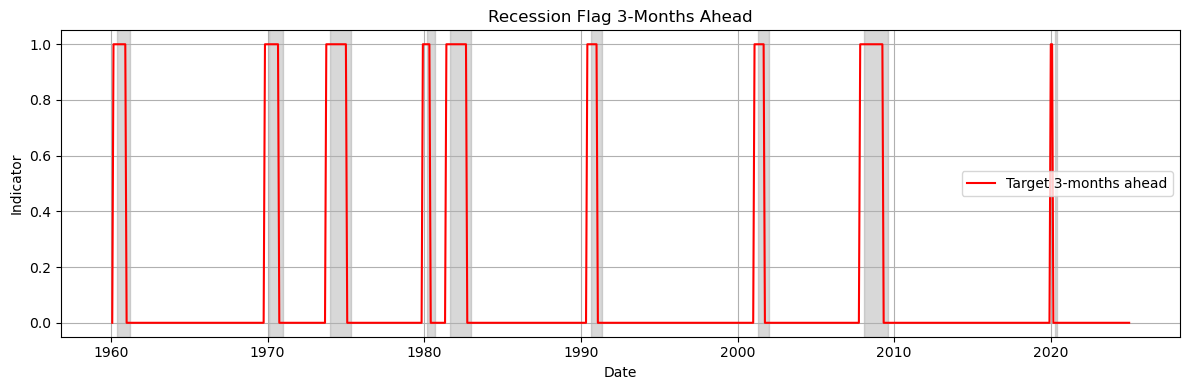

In [97]:
# Plot 3-month-ahead recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y.index, y, color='red', label='Target 3-months ahead')

# Shade actual recession periods
in_recession = False
start_date = None

for date, flag in y_now.items():
    if flag and not in_recession:
        # mark recession start
        in_recession = True
        start_date = date
    elif not flag and in_recession:
        # mark recession end
        in_recession = False
        plt.axvspan(start_date, date, color='gray', alpha=0.3)

# shade if recession continues through end of series
if in_recession:
    plt.axvspan(start_date, y_now.index[-1], color='gray', alpha=0.3)

# finalize plot styling
plt.title("Recession Flag 3-Months Ahead")
plt.xlabel("Date")
plt.ylabel("Indicator")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("1- target_shifted.png", dpi=600, bbox_inches='tight')
plt.show()

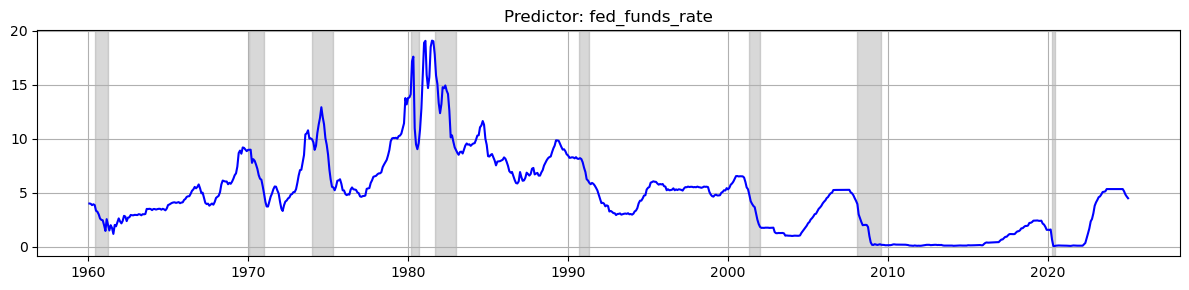

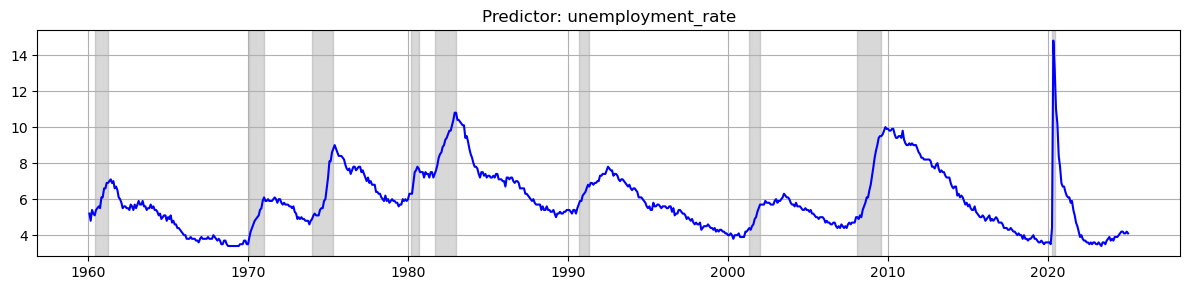

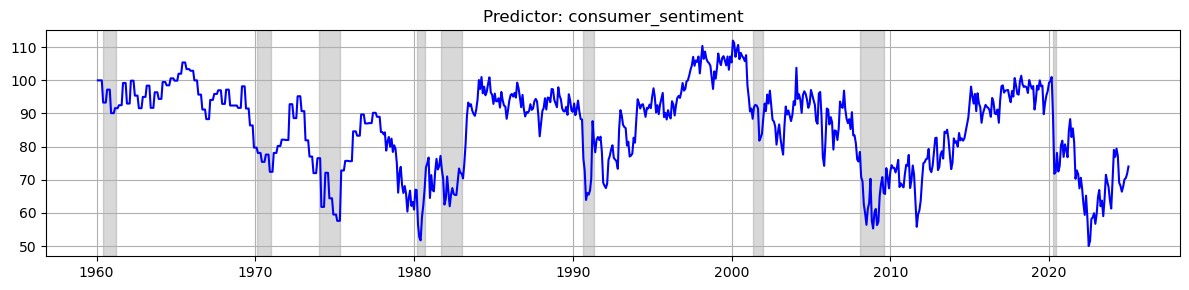

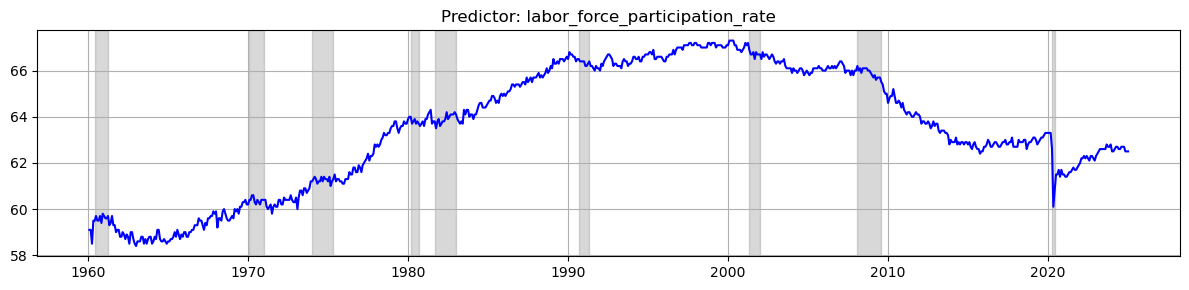

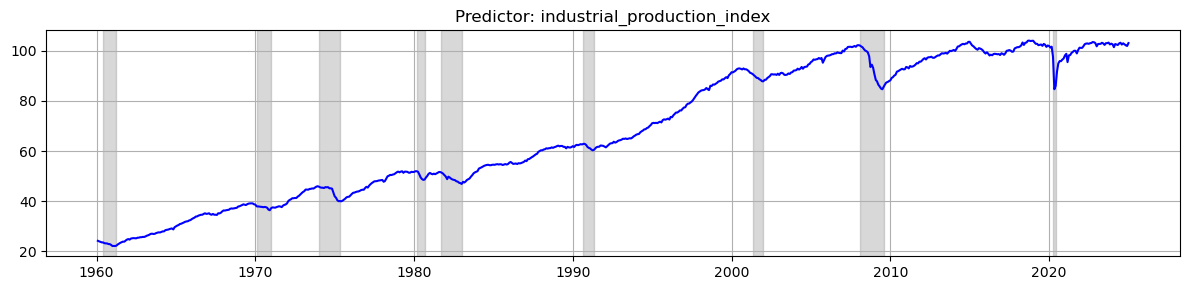

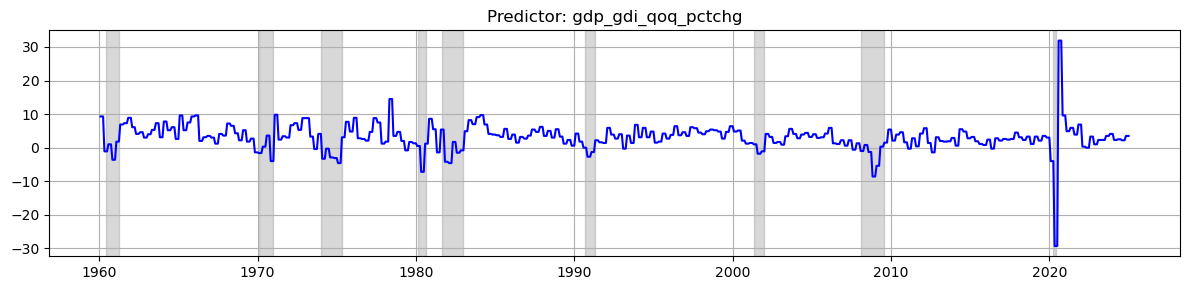

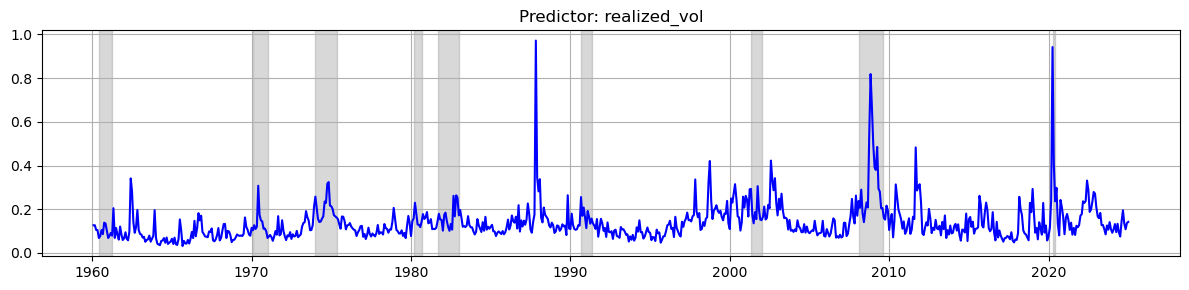

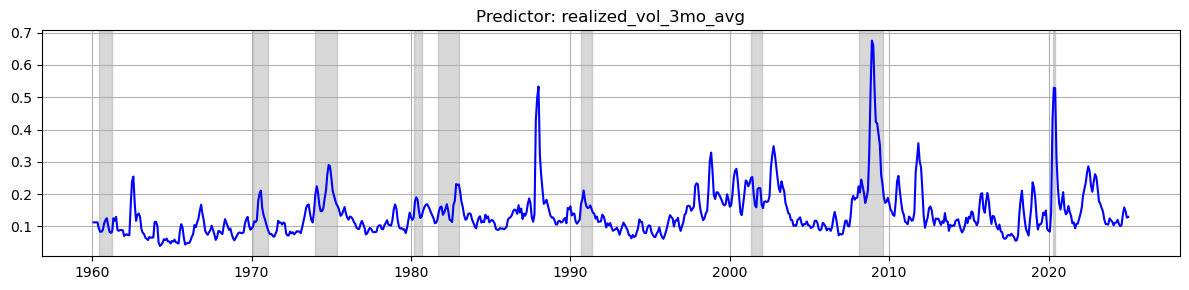

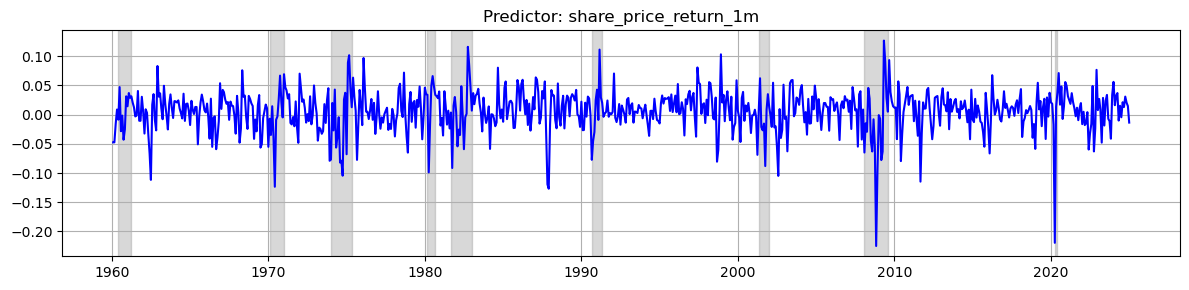

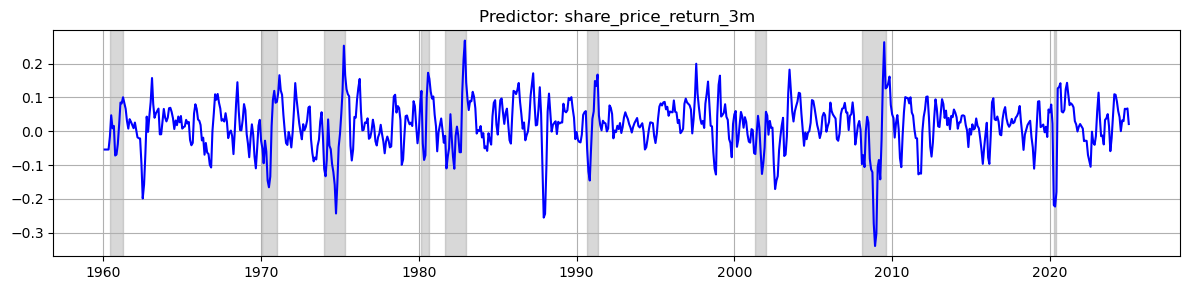

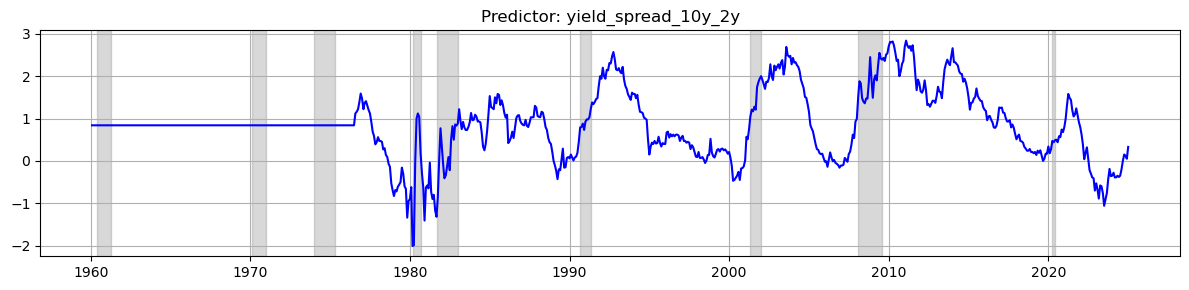

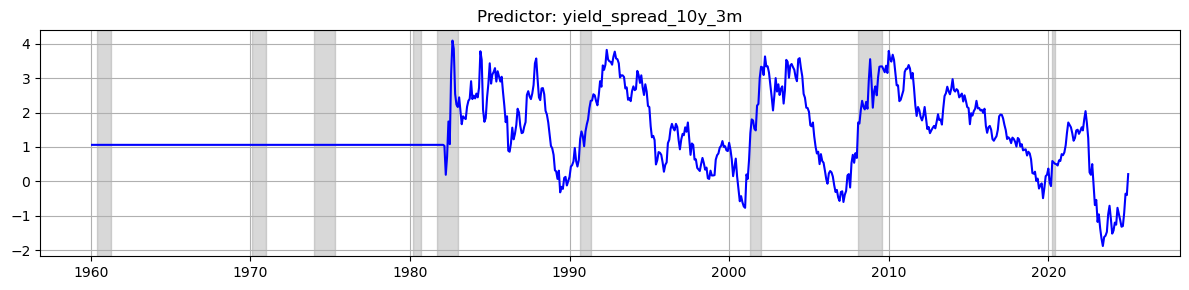

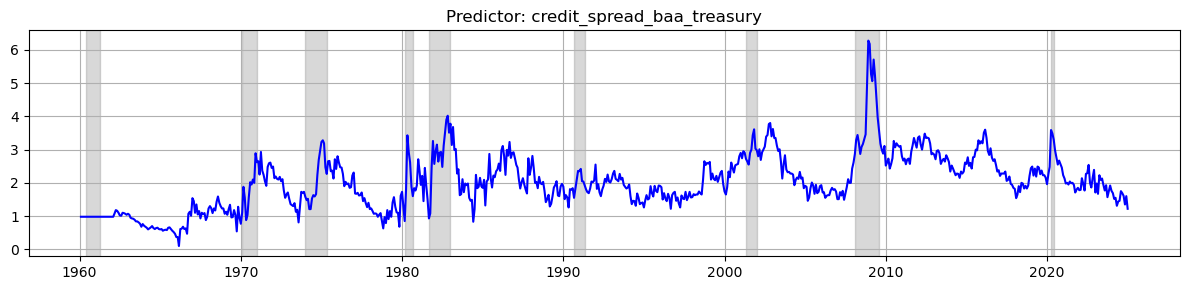

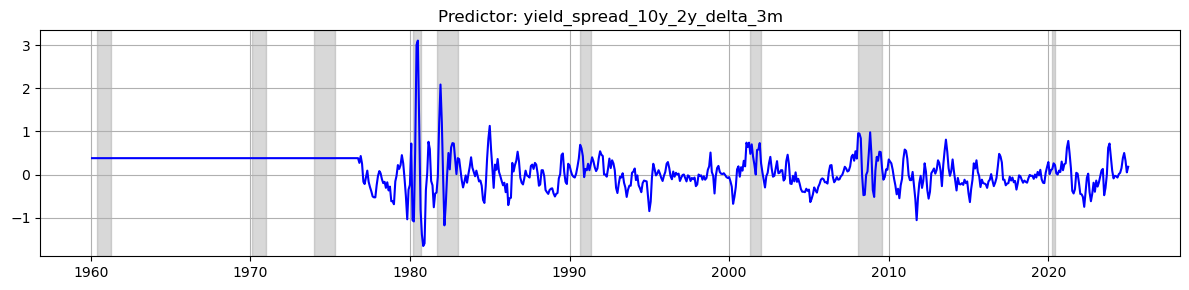

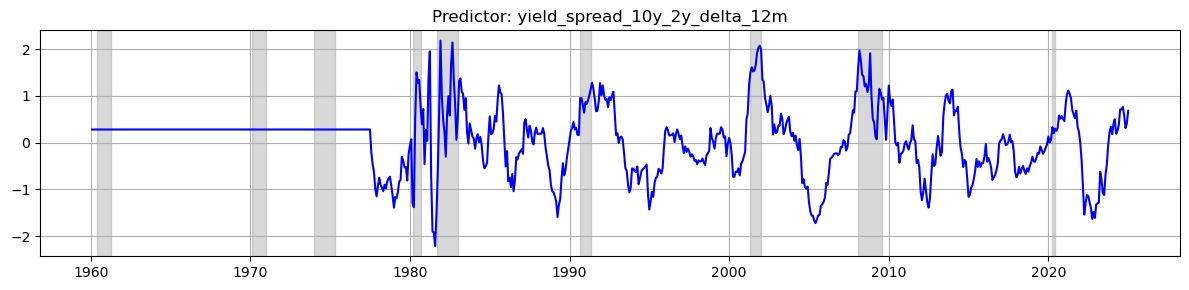

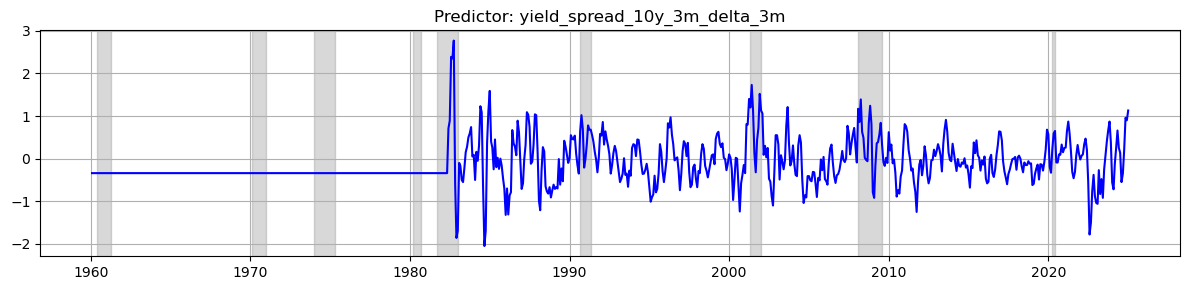

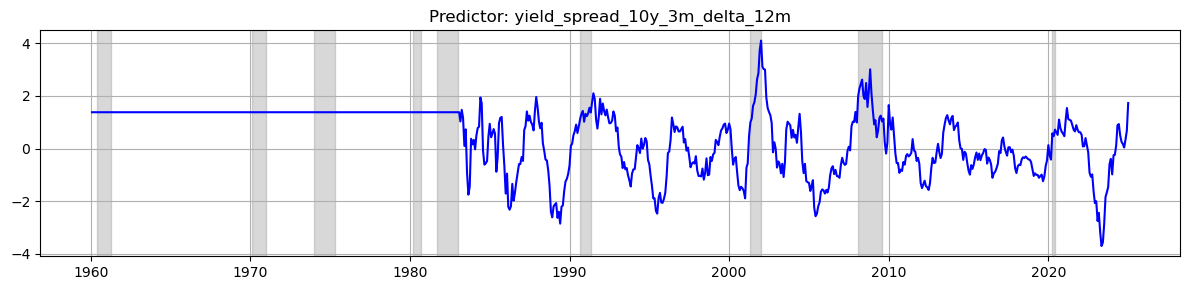

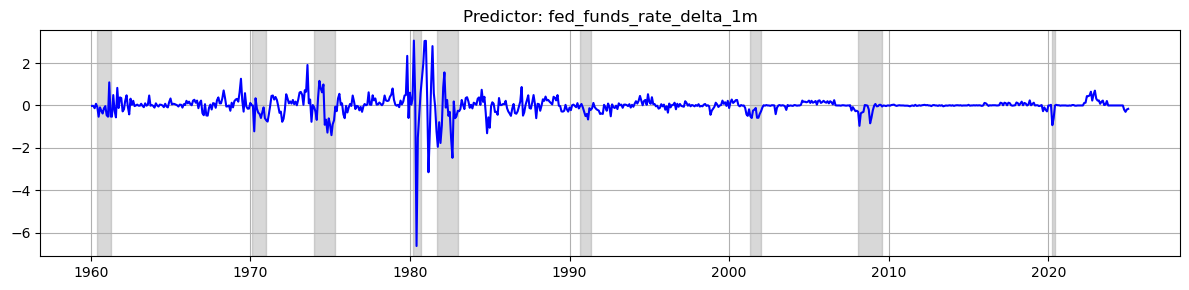

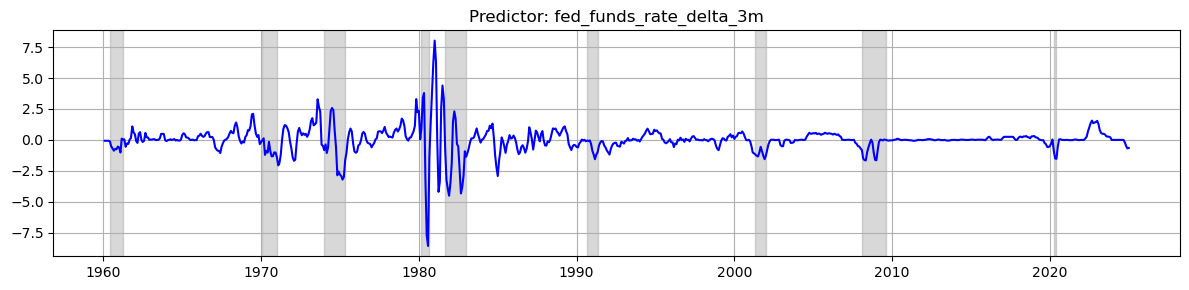

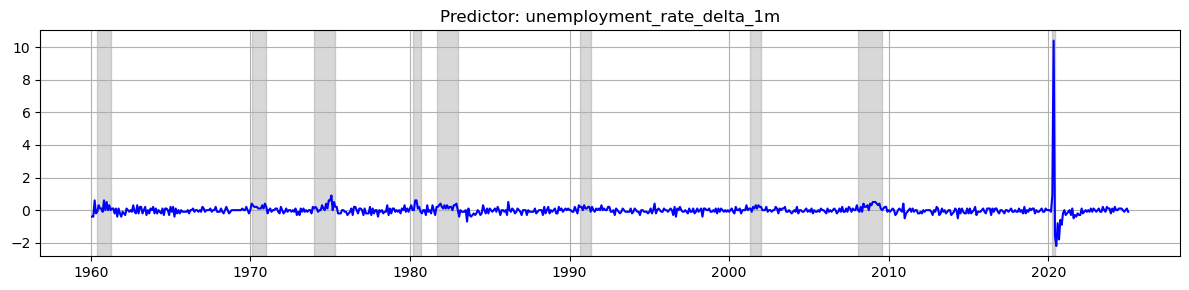

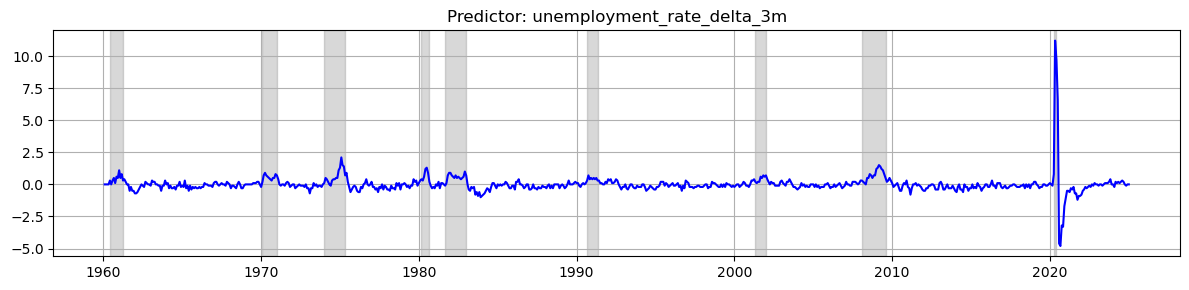

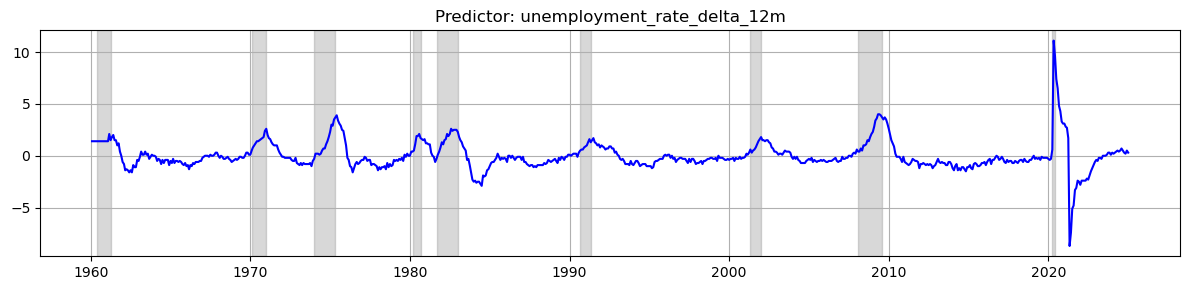

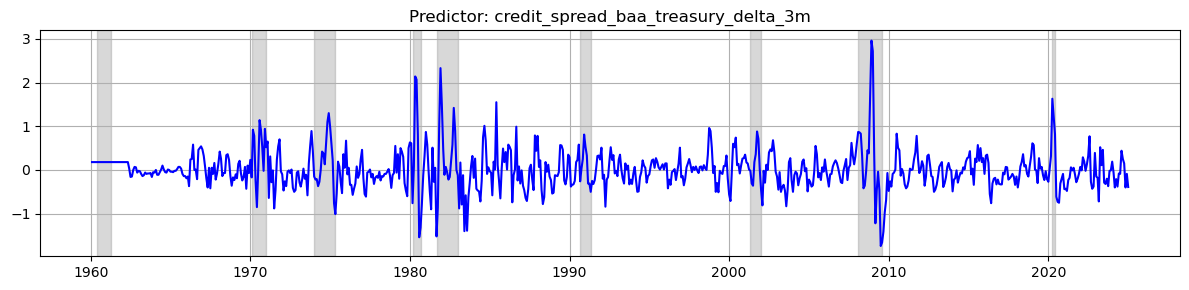

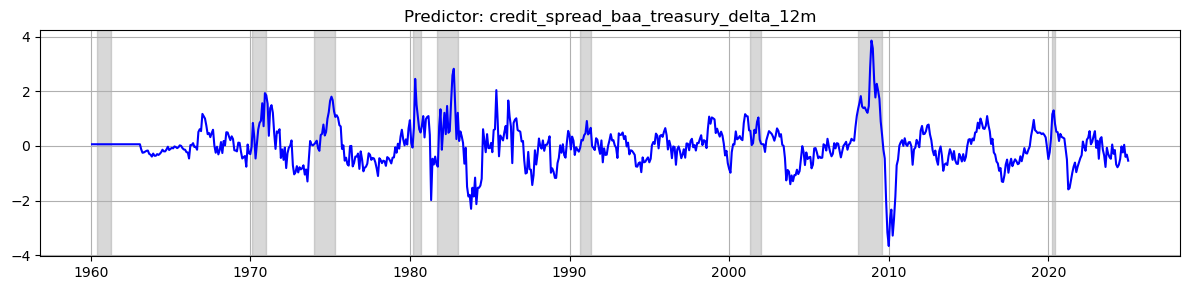

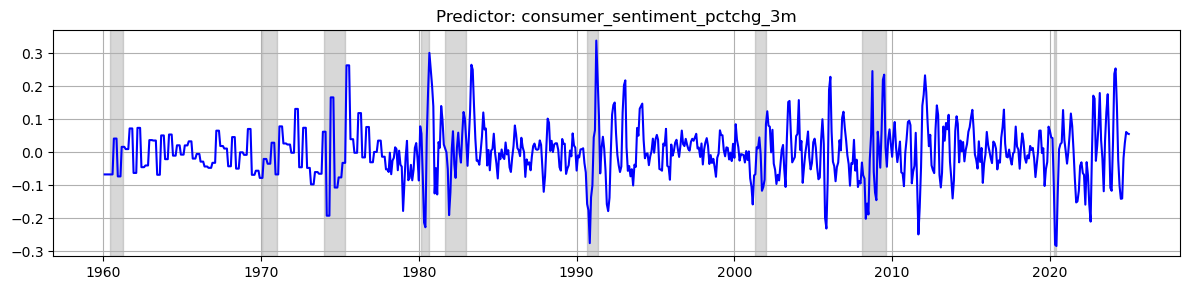

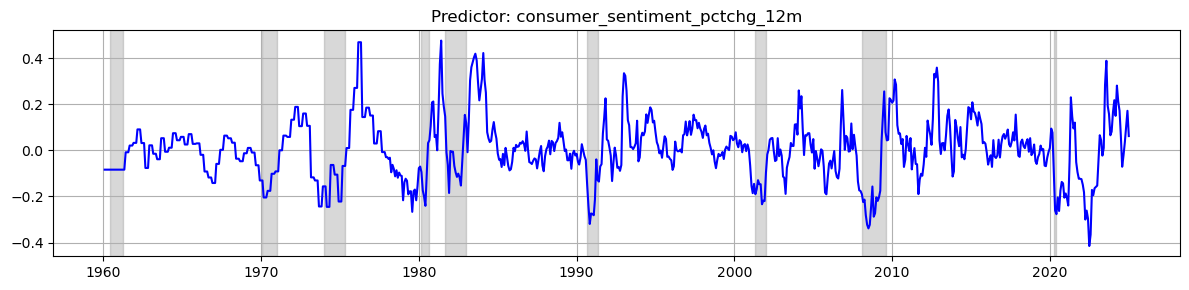

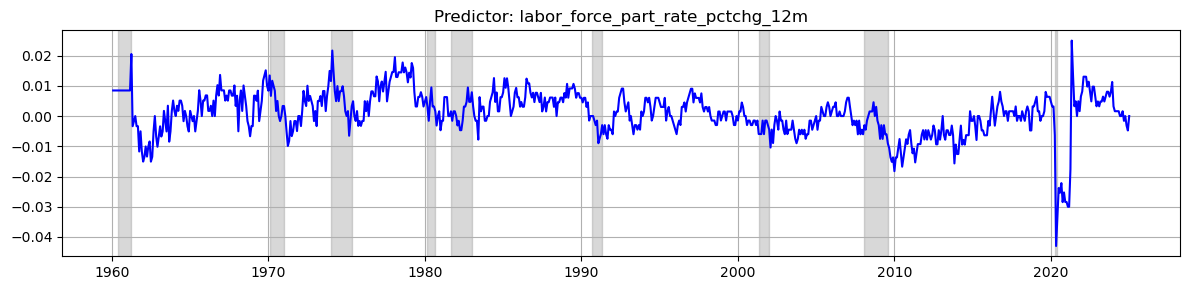

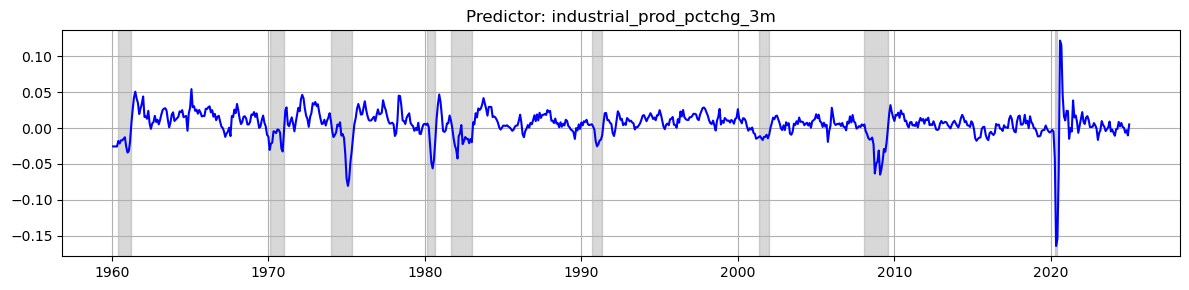

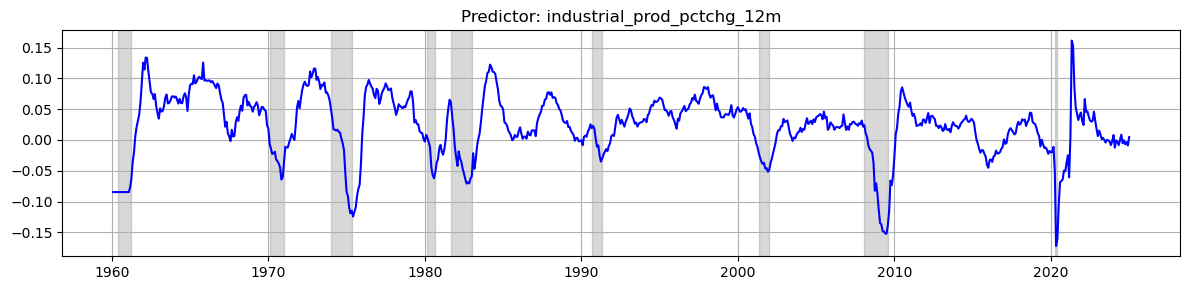

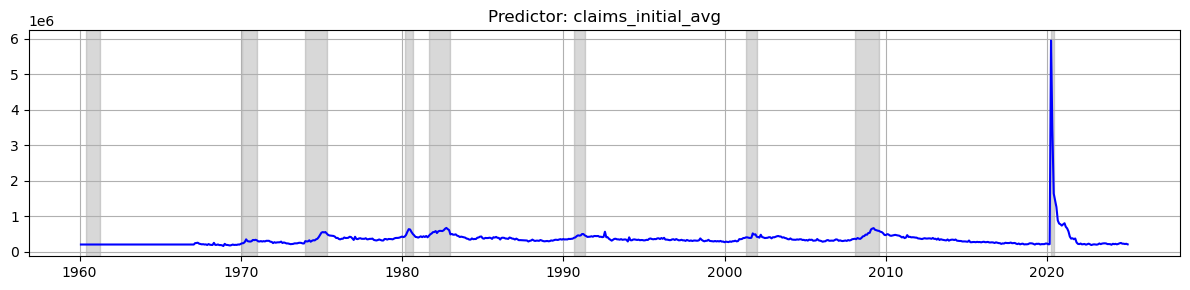

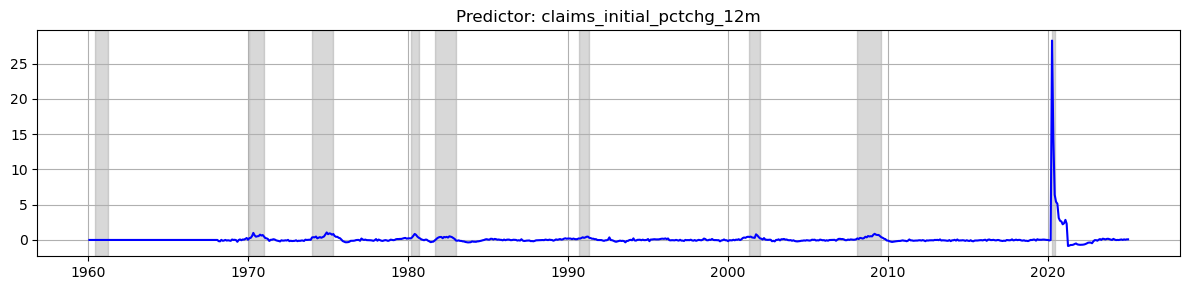

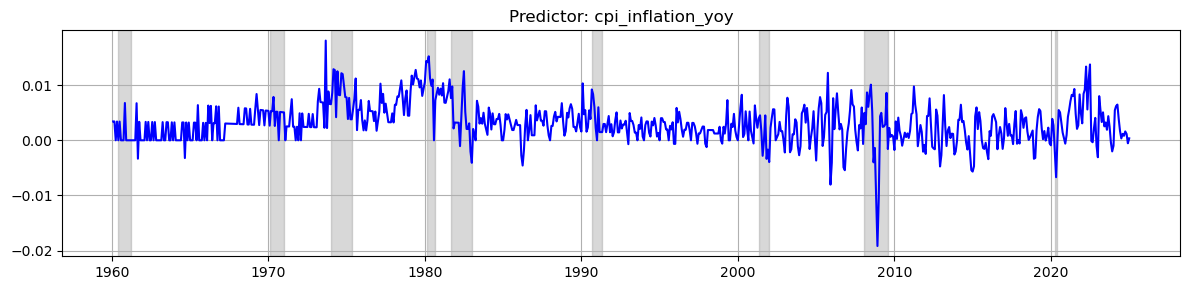

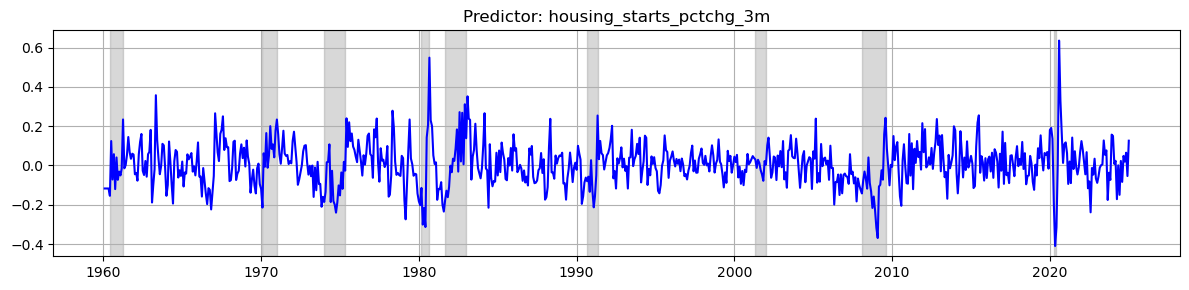

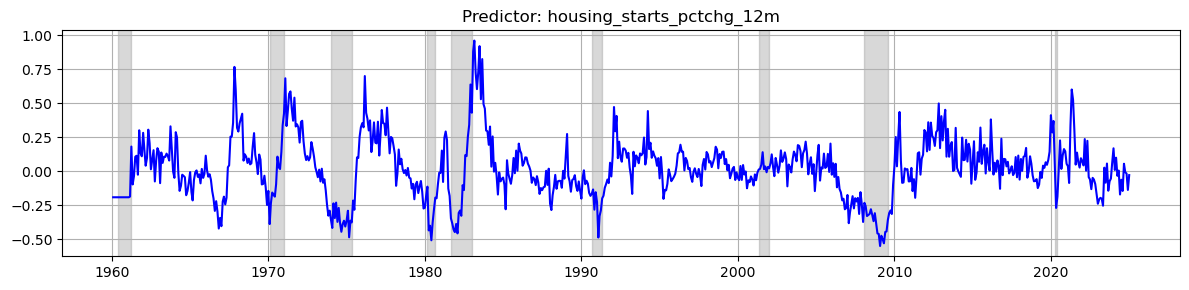

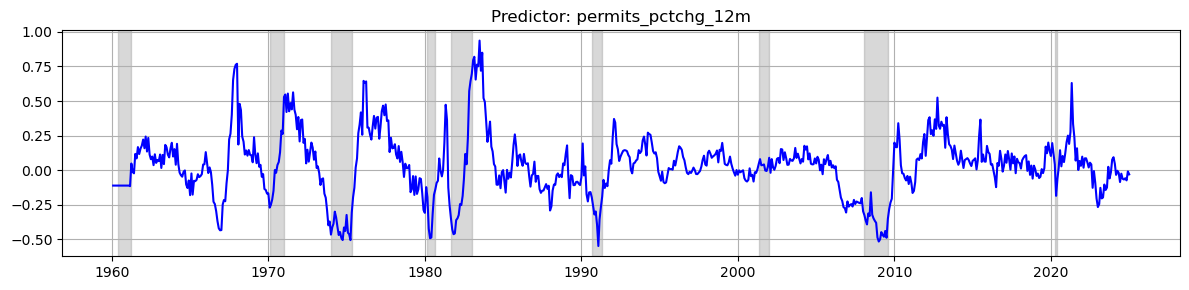

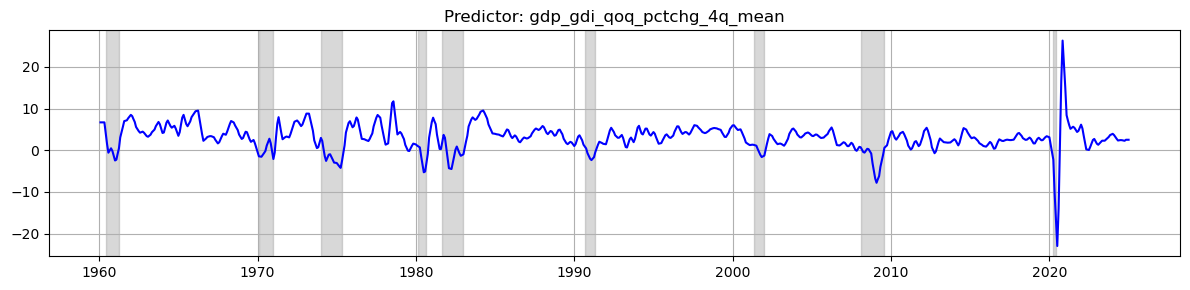

In [98]:
# Plot each predictor series with recession shading
for col in X.columns:
    # create new plot
    plt.figure(figsize=(12, 3))
    # draw predictor time series
    plt.plot(X.index, X[col], color='blue', label=f'Predictor: {col}')

    # identify and shade recession intervals
    in_rec = False
    start_rec = None
    for date, is_rec in y_now.items():
        if is_rec and not in_rec:
            in_rec = True
            start_rec = date
        elif not is_rec and in_rec:
            in_rec = False
            plt.axvspan(start_rec, date, color='gray', alpha=0.3)
    if in_rec:
        plt.axvspan(start_rec, X.index[-1], color='gray', alpha=0.3)

    # finalize and save plot
    plt.title(f"Predictor: {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"2- predictor_{col}.png", dpi=600, bbox_inches='tight')
    plt.show()

In [99]:
# Display summary statistics of all features for verification
features.describe()

fed_funds_rate  unemployment_rate  consumer_sentiment  \
count      780.000000         780.000000          780.000000   
mean         4.799372           5.887821           85.698077   
std          3.643401           1.696895           12.739695   
min          0.050000           3.400000           50.000000   
25%          1.945000           4.700000           76.175000   
50%          4.750000           5.600000           89.350000   
75%          6.522500           7.000000           95.100000   
max         19.100000          14.800000          112.000000   

       labor_force_participation_rate  industrial_production_index  \
count                      780.000000                   780.000000   
mean                        63.504872                    68.375987   
std                          2.660436                    26.467599   
min                         58.400000                    22.096000   
25%                         61.400000                    45.381900   
50%                         63.700000                    63.271300   
75%                         66.100000                    95.736450   
max                         67.300000                   104.103800   

       gdp_gdi_qoq_pctchg  realized_vol  realized_vol_3mo_avg  \
count          780.000000    780.000000            780.000000   
mean             3.086923      0.138875              0.138811   
std              4.107432      0.086190              0.073105   
min            -29.300000      0.031882              0.039024   
25%              1.475000      0.089243              0.094893   
50%              3.100000      0.117522              0.120015   
75%              4.800000      0.163898              0.161782   
max             31.900000      0.971439              0.675552   

       share_price_return_1m  share_price_return_3m  ...  \
count             780.000000             780.000000  ...   
mean                0.005717               0.017987  ...   
std                 0.035920               0.071274  ...   
min                -0.224867              -0.338856  ...   
25%                -0.011416              -0.018321  ...   
50%                 0.008722               0.023582  ...   
75%                 0.027330               0.059456  ...   
max                 0.126674               0.267625  ...   

       industrial_prod_pctchg_12m  claims_initial_avg  \
count                  780.000000        7.800000e+02   
mean                     0.022952        3.485346e+05   
std                      0.049382        2.627599e+05   
min                     -0.172023        1.620000e+05   
25%                      0.000106        2.410000e+05   
50%                      0.027343        3.295000e+05   
75%                      0.054707        3.900000e+05   
max                      0.161199        5.946000e+06   

       claims_initial_pctchg_12m  cpi_inflation_yoy  housing_starts_pctchg_3m  \
count                 780.000000         780.000000                780.000000   
mean                    0.097371           0.003063                  0.005646   
std                     1.231899           0.003573                  0.109965   
min                    -0.889337          -0.019153                 -0.410013   
25%                    -0.101609           0.000702                 -0.060841   
50%                    -0.029412           0.002906                  0.005568   
75%                     0.053082           0.005081                  0.063815   
max                    28.290640           0.018059                  0.635875   

       housing_starts_pctchg_12m  permits_pctchg_12m  \
count                 780.000000          780.000000   
mean                    0.021566            0.028861   
std                     0.218030            0.223117   
min                    -0.547970           -0.550343   
25%                    -0.098077           -0.086309   
50%                     0.015652            0.036155   
75%                     0.132359    

In [100]:
# Display data types and non-null counts for all features
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 1960-01-31 to 2024-12-31
Freq: ME
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   fed_funds_rate                        780 non-null    float64
 1   unemployment_rate                     780 non-null    float64
 2   consumer_sentiment                    780 non-null    float64
 3   labor_force_participation_rate        780 non-null    float64
 4   industrial_production_index           780 non-null    float64
 5   gdp_gdi_qoq_pctchg                    780 non-null    float64
 6   realized_vol                          780 non-null    float64
 7   realized_vol_3mo_avg                  780 non-null    float64
 8   share_price_return_1m                 780 non-null    float64
 9   share_price_return_3m                 780 non-null    float64
 10  yield_spread_10y_2y                   780 non-null    floa

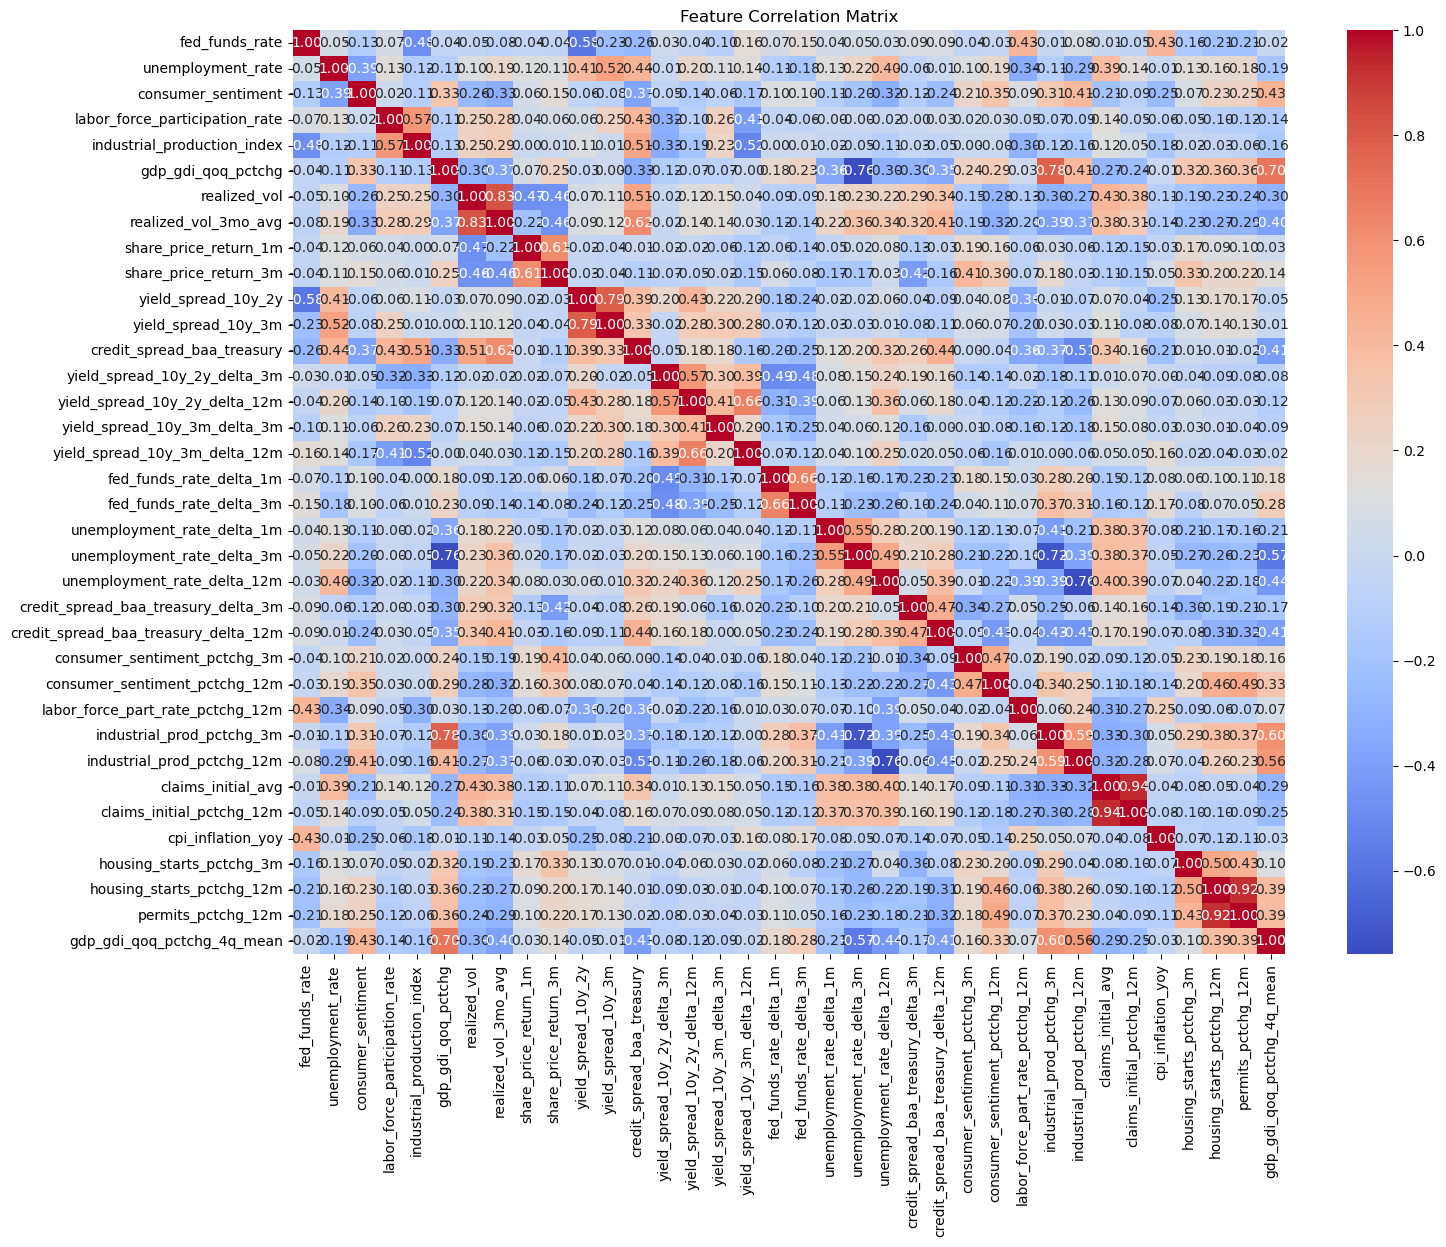

In [101]:
# Compute pairwise feature correlations
correlation_matrix = X.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.savefig('3- correlation_matrix.png', dpi=600, bbox_inches='tight')
plt.show()

### Baseline Logistic

In [103]:
# Forward/backward fill missing values
X_filled = X.ffill().bfill()
y_filled = y.ffill().bfill()

# Standardize features: zero mean, unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Chronologically split data: 60% train, 40% validation
n = len(X_scaled_df)
train_end = int(n * 0.6)
X_train = X_scaled_df.iloc[:train_end]
y_train = y_filled.iloc[:train_end]
X_val = X_scaled_df.iloc[train_end:]
y_val = y_filled.iloc[train_end:]

# Train logistic regression and predict validation probabilities
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
probs = model.predict_proba(X_val)[:, 1]

# Optimize threshold by maximizing PR-curve F1 score
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores = 2 * prec * rec / (prec + rec)
best_idx = np.nanargmax(f1_scores)
best_thresh = th[best_idx]

# Binarize predictions using optimal threshold
flags = (probs >= best_thresh).astype(int)

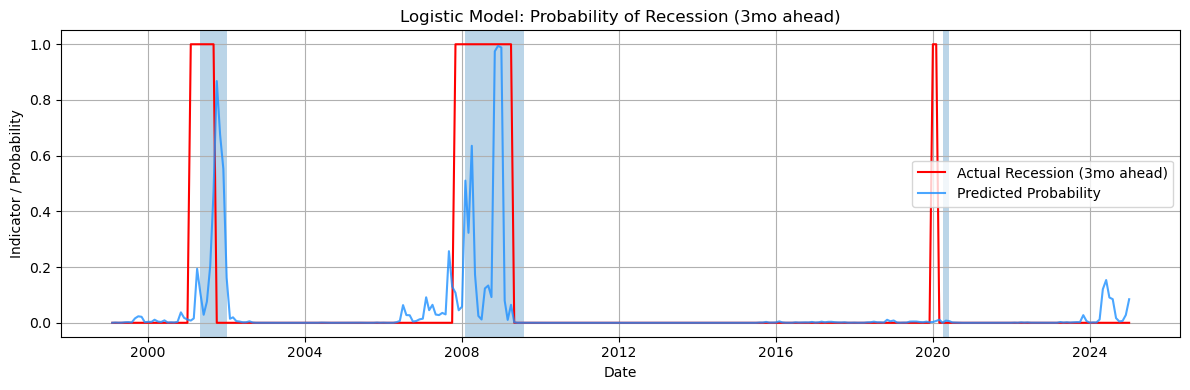

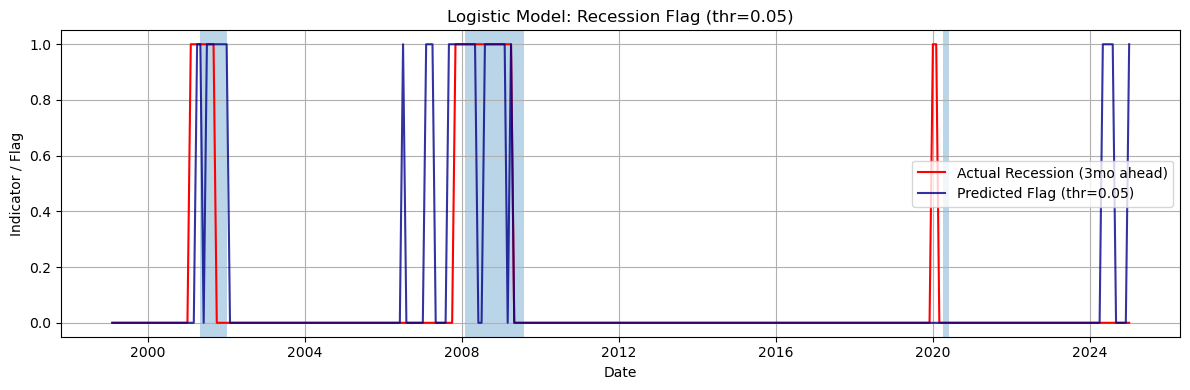

In [104]:
# Restrict recession series to validation period
y_now_trunc = y_now.loc[y_now.index >= y_val.index[0]]

# Plot predicted probabilities vs actual recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val, label='Actual Recession (3mo ahead)', color='red')
plt.plot(y_val.index, probs, label='Predicted Probability', color='dodgerblue', alpha=0.8)

# Highlight actual recession intervals
in_rec = False
start_rec = None
for date, flag in y_now_trunc.items():
    if flag and not in_rec:
        in_rec = True
        start_rec = date
    elif not flag and in_rec:
        in_rec = False
        plt.axvspan(start_rec, date, alpha=0.3)
if in_rec:
    plt.axvspan(start_rec, y_val.index[-1], alpha=0.3)

plt.title('Logistic Model: Probability of Recession (3mo ahead)')
plt.xlabel('Date')
plt.ylabel('Indicator / Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('4- Baseline Logistic (Probability).png', dpi=600, bbox_inches='tight')
plt.show()

# Plot predicted binary flags vs actual recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val, label='Actual Recession (3mo ahead)', color='red')
plt.plot(y_val.index, flags, label=f'Predicted Flag (thr={best_thresh:.2f})', color='darkblue', alpha=0.8)

# Highlight actual recession intervals
in_rec = False
start_rec = None
for date, flag in y_now_trunc.items():
    if flag and not in_rec:
        in_rec = True
        start_rec = date
    elif not flag and in_rec:
        in_rec = False
        plt.axvspan(start_rec, date, alpha=0.3)
if in_rec:
    plt.axvspan(start_rec, y_val.index[-1], alpha=0.3)

plt.title(f'Logistic Model: Recession Flag (thr={best_thresh:.2f})')
plt.xlabel('Date')
plt.ylabel('Indicator / Flag')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'5- Baseline Logistic (Flag thr={best_thresh:.2f}).png', dpi=600, bbox_inches='tight')
plt.show()

### Logistic + Random Forest + Stacking Classifier

---



In [106]:
# Fill missing feature and target values
X_filled = X.ffill().bfill()
y_filled = y.ffill().bfill()

# Add lagged recession flag features
for lag in (1, 2, 3):
    X_filled[f'recession_lag{lag}'] = y_filled.shift(lag)

# Replace infinite values and refill missing entries
X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# Standardize features to zero mean and unit variance
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)

# Split data chronologically: 60% train, 40% validation
n = len(X_scaled_df)
train_end = int(n * 0.6)
X_train = X_scaled_df.iloc[:train_end]
y_train = y_filled.iloc[:train_end]
X_val = X_scaled_df.iloc[train_end:]
y_val = y_filled.iloc[train_end:]

# Grid search for L1-regularized logistic regression with time-series CV
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear']}
grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1
)
grid.fit(X_train, y_train)
best_lr = grid.best_estimator_

# Train stacking classifier with logistic and random forest base learners
base_rf = RandomForestClassifier(
    n_estimators=200, max_depth=5,
    class_weight='balanced_subsample', random_state=42
)
stack = StackingClassifier(
    estimators=[('lr', best_lr), ('rf', base_rf)],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5, n_jobs=-1
)
stack.fit(X_train, y_train)

# Compute validation probabilities
probs = stack.predict_proba(X_val)[:, 1]

# Select threshold maximizing F1 on precision–recall curve
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores = 2 * prec * rec / (prec + rec)
best_thresh = th[np.nanargmax(f1_scores)]

# Generate binary flags using optimal threshold
flags = (probs >= best_thresh).astype(int)

In [107]:
# Extract fitted logistic and random forest estimators from the stack
lr_clf = stack.named_estimators_['lr']
rf_clf = stack.named_estimators_['rf']

# Get validation feature names
features = X_val.columns

# Build DataFrame of logistic coefficients
coef = lr_clf.coef_[0]
lr_df = pd.DataFrame({
    'Feature': features,
    'Weight':  coef
})
# Sort by absolute coefficient magnitude
lr_df['AbsWeight'] = lr_df['Weight'].abs()
lr_df = lr_df.sort_values('AbsWeight', ascending=False).reset_index(drop=True)

# Select top and bottom five features by absolute weight
top5_lr = lr_df.head(5)[['Feature', 'Weight']].rename(columns={'Weight': 'Weight (signed)'})
bot5_lr = lr_df.tail(5)[['Feature', 'Weight']].rename(columns={'Weight': 'Weight (signed)'})

# Build DataFrame of random forest feature importances
imp = rf_clf.feature_importances_
rf_df = pd.DataFrame({
    'Feature':    features,
    'Importance': imp
})
# Sort importances in descending order
rf_df = rf_df.sort_values('Importance', ascending=False).reset_index(drop=True)
top5_rf = rf_df.head(5)

# Display results in markdown tables
print("### Logistic Regression (top 5 by |weight|)")
print(top5_lr.to_markdown(index=False))

print("\n### Logistic Regression (5 least influential)")
print(bot5_lr.to_markdown(index=False))

print("\n### Random Forest (top 5 by importance)")
print(top5_rf.to_markdown(index=False))

### Logistic Regression (top 5 by |weight|)
| Feature                    |   Weight (signed) |
|:---------------------------|------------------:|
| recession_lag1             |          1.52697  |
| permits_pctchg_12m         |         -0.268298 |
| fed_funds_rate             |          0.255085 |
| housing_starts_pctchg_3m   |         -0.23206  |
| industrial_prod_pctchg_12m |         -0.198352 |

### Logistic Regression (5 least influential)
| Feature                    |   Weight (signed) |
|:---------------------------|------------------:|
| cpi_inflation_yoy          |                 0 |
| housing_starts_pctchg_12m  |                 0 |
| gdp_gdi_qoq_pctchg_4q_mean |                 0 |
| recession_lag2             |                 0 |
| recession_lag3             |                 0 |

### Random Forest (top 5 by importance)
| Feature                   |   Importance |
|:--------------------------|-------------:|
| recession_lag1            |    0.180589  |
| permits_pctchg_12

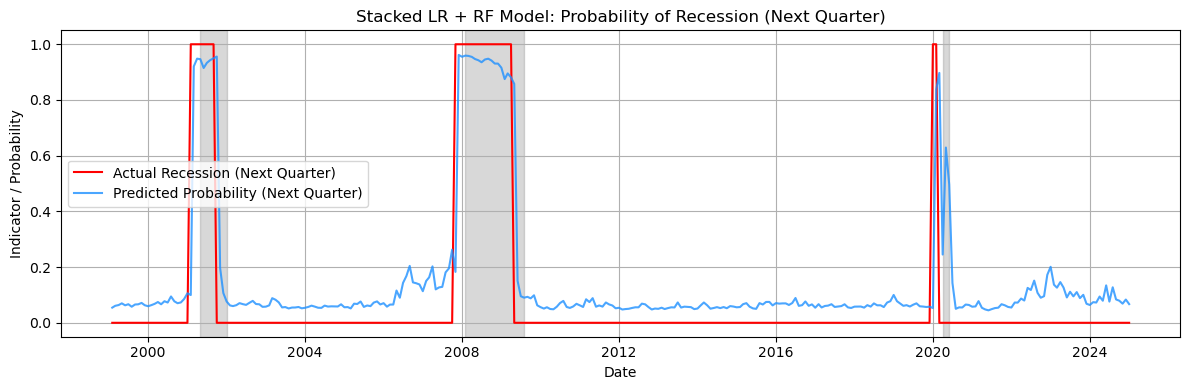

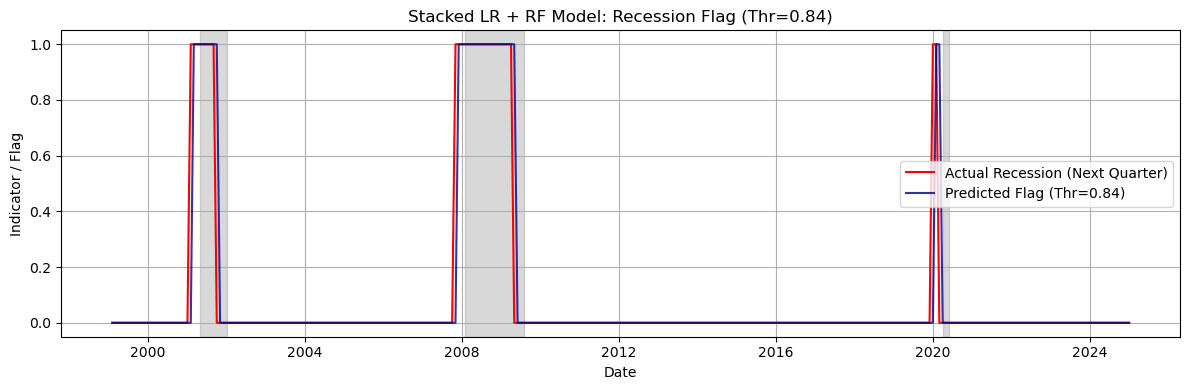

In [108]:
# Limit recession indicator to validation period
y_now_trunc = y_now.loc[y_now.index >= y_val.index[0]]

# Plot predicted probabilities vs actual recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val, color='red', label='Actual Recession (Next Quarter)')
plt.plot(y_val.index, probs, color='dodgerblue', alpha=0.8, label='Predicted Probability (Next Quarter)')

# Highlight actual recession intervals
in_rec = False
rec_start = None
for date, is_rec in y_now_trunc.items():
    if is_rec and not in_rec:
        in_rec = True
        rec_start = date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(rec_start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(rec_start, y_val.index[-1], color='gray', alpha=0.3)

# Finalize and save probability plot
plt.title("Stacked LR + RF Model: Probability of Recession (Next Quarter)")
plt.xlabel("Date")
plt.ylabel("Indicator / Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("6- Stacked LR+RF (Probability).png", dpi=600, bbox_inches='tight')
plt.show()

# Plot predicted binary flags vs actual recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val, color='red', label='Actual Recession (Next Quarter)')
plt.plot(y_val.index, flags, color='darkblue', alpha=0.8, label=f'Predicted Flag (Thr={best_thresh:.2f})')

# Highlight actual recession intervals
in_rec = False
rec_start = None
for date, is_rec in y_now_trunc.items():
    if is_rec and not in_rec:
        in_rec = True
        rec_start = date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(rec_start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(rec_start, y_val.index[-1], color='gray', alpha=0.3)

# Finalize and save flag plot
plt.title(f"Stacked LR + RF Model: Recession Flag (Thr={best_thresh:.2f})")
plt.xlabel("Date")
plt.ylabel("Indicator / Flag")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"7- Stacked LR+RF (Flag Thr={best_thresh:.2f}).png", dpi=600, bbox_inches='tight')
plt.show()

### LightGBM with SMOTE oversampling

In [110]:
# Fill missing feature and target values
X_filled = X.ffill().bfill()
y_filled = y.ffill().bfill()

# Add lagged recession flag features
for lag in (1, 2, 3):
    X_filled[f'recession_lag{lag}'] = y_filled.shift(lag)

# Replace infinities and refill missing entries
X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# Standardize features to zero mean and unit variance
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)

# Chronological split: 60% train, 40% validation
n = len(X_scaled_df)
train_end = int(n * 0.6)
X_train, X_val = X_scaled_df.iloc[:train_end], X_scaled_df.iloc[train_end:]
y_train, y_val = y_filled.iloc[:train_end], y_filled.iloc[train_end:]

# Balance classes via SMOTE on the training set
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# LightGBM hyperparameter tuning with time-series CV
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 300],
    'num_leaves': [15, 31],
    'max_depth': [4, 6, -1],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
grid = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1
)
grid.fit(X_res, y_res)
best_lgbm = grid.best_estimator_

# Compute validation probabilities
probs = best_lgbm.predict_proba(X_val)[:, 1]

# Select threshold maximizing PR-curve F1 score
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores = 2 * prec * rec / (prec + rec)
best_thresh = th[np.nanargmax(f1_scores)]

# Generate binary flags using optimal threshold
flags = (probs >= best_thresh).astype(int)

[LightGBM] [Info] Number of positive: 401, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8386
[LightGBM] [Info] Number of data points in the train set: 802, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Info] Number of positive: 401, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8386
[LightGBM] [Info] Number of data points in the train set: 802, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

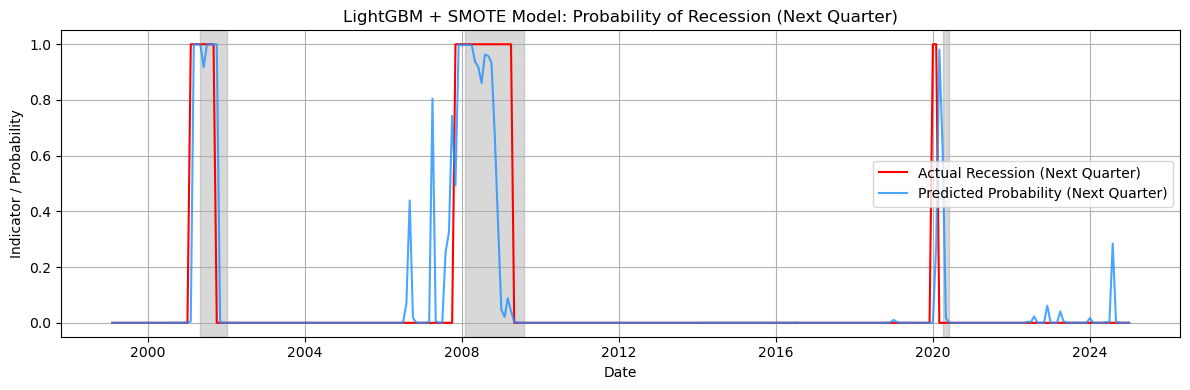

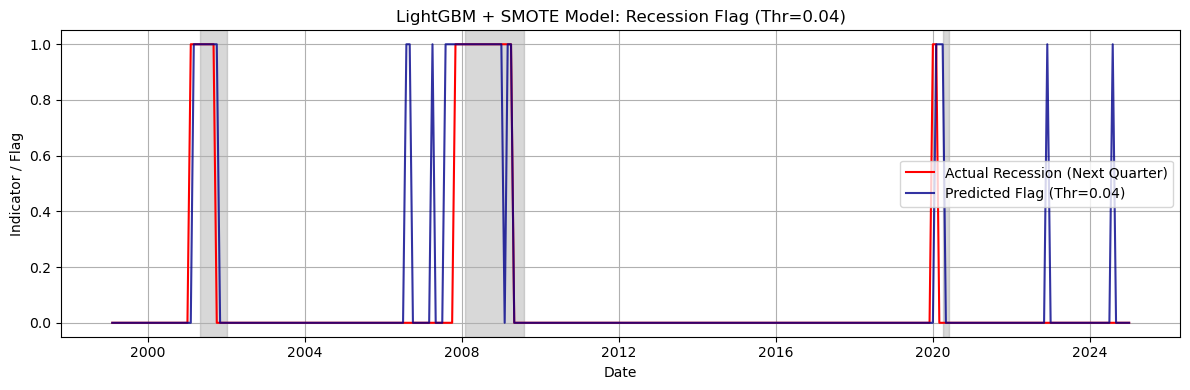

In [111]:
# Fill missing feature and target values
X_filled = X.ffill().bfill()
y_filled = y.ffill().bfill()

# Add lagged recession flag features
for lag in (1, 2, 3):
    X_filled[f'recession_lag{lag}'] = y_filled.shift(lag)

# Replace infinities and refill missing entries
X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# Standardize features to zero mean and unit variance
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)

# Chronological split: 60% train, 40% validation
n = len(X_scaled_df)
train_end = int(n * 0.6)
X_train, X_val = X_scaled_df.iloc[:train_end], X_scaled_df.iloc[train_end:]
y_train, y_val = y_filled.iloc[:train_end], y_filled.iloc[train_end:]

# Balance classes via SMOTE on the training set
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# LightGBM hyperparameter tuning with time-series CV
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 300],
    'num_leaves': [15, 31],
    'max_depth': [4, 6, -1],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
grid = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1
)
grid.fit(X_res, y_res)
best_lgbm = grid.best_estimator_

# Compute validation probabilities
probs = best_lgbm.predict_proba(X_val)[:, 1]

# Select threshold maximizing PR-curve F1 score
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores = 2 * prec * rec / (prec + rec)
best_thresh = th[np.nanargmax(f1_scores)]

# Generate binary flags using optimal threshold
flags = (probs >= best_thresh).astype(int)

# Restrict recession indicator to validation period for plotting
y_now_trunc = y_now.loc[y_now.index >= y_val.index[0]]

# Plot predicted probabilities vs actual recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val, color='red', label='Actual Recession (Next Quarter)')
plt.plot(y_val.index, probs, color='dodgerblue', alpha=0.8, label='Predicted Probability (Next Quarter)')

# Highlight actual recession intervals
in_rec = False
rec_start = None
for date, is_rec in y_now_trunc.items():
    if is_rec and not in_rec:
        in_rec = True
        rec_start = date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(rec_start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(rec_start, y_val.index[-1], color='gray', alpha=0.3)

# Finalize and save probability plot
plt.title('LightGBM + SMOTE Model: Probability of Recession (Next Quarter)')
plt.xlabel('Date')
plt.ylabel('Indicator / Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('8- LightGBM + SMOTE (Probability).png', dpi=600, bbox_inches='tight')
plt.show()

# Plot predicted binary flags vs actual recession indicator
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val, color='red', label='Actual Recession (Next Quarter)')
plt.plot(y_val.index, flags, color='darkblue', alpha=0.8, label=f'Predicted Flag (Thr={best_thresh:.2f})')

# Highlight actual recession intervals
in_rec = False
rec_start = None
for date, is_rec in y_now_trunc.items():
    if is_rec and not in_rec:
        in_rec = True
        rec_start = date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(rec_start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(rec_start, y_val.index[-1], color='gray', alpha=0.3)

# Finalize and save flag plot
plt.title(f"LightGBM + SMOTE Model: Recession Flag (Thr={best_thresh:.2f})")
plt.xlabel('Date')
plt.ylabel('Indicator / Flag')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"9- LightGBM + SMOTE (Flag Thr={best_thresh:.2f}).png", dpi=600, bbox_inches='tight')
plt.show()

### Custom Coverage Metric

In [113]:
def coverage_score(actual, preds):
    """
    For each true recession segment [start, end), compute the fraction of days
    in that segment where preds==1, then average across all segments.

    Returns a number in [0, 1]: 1 means you flagged *every* day of every recession.
    """
    # pad to detect edges
    a = np.concatenate(([0], actual, [0]))
    d = np.diff(a)

    # diff==1 marks the first day of a recession; diff==-1 marks one past the last day
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0]

    coverages = []
    for s, e in zip(starts, ends):
        # true recession runs from index s to e-1 of `actual`
        length = e - s
        if length <= 0:
            continue
        # compute fraction of days flagged in this segment
        coverage = np.sum(preds[s:e]) / length
        coverages.append(coverage)

    # no recessions found → return NaN
    if not coverages:
        return np.nan

    # return mean coverage over all segments
    return np.mean(coverages)

### Custom Timing Metric

In [115]:
def compute_timing_score(
    actual, preds,
    k_start_early=3, k_start_late=1,
    k_end=2
):
    """
    Custom timing score ∈ [-1,1] with three scales:
      - k_start_early: reward scale for early start predictions (delta>0)
      - k_start_late:  penalty scale for late start predictions (delta<0)
      - k_end:         unified scale for both early and late end predictions

    actual: 1D array of 0/1 true recession indicator
    preds : 1D array of 0/1 model predictions
    """
    import numpy as np

    n = len(actual)
    # True event indices: starts where actual goes 0→1, ends where 1→0
    starts = np.where((actual == 1) & (np.concatenate([[0], actual[:-1]]) == 0))[0]
    ends   = np.where((actual == 0) & (np.concatenate([[1], actual[:-1]]) == 1))[0]

    # Predicted event indices: analogous to true events
    pred_starts = np.where((preds == 1) & (np.concatenate([[0], preds[:-1]]) == 0))[0]
    pred_ends   = np.where((preds == 0) & (np.concatenate([[1], preds[:-1]]) == 1))[0]

    scores = []

    # Exponential scoring helpers
    def _reward(delta, k):
        return np.exp(-delta / k)
    def _penalty(delta, k):
        return -(1 - np.exp(delta / k))

    # Score start predictions relative to true starts
    for t in starts:
        if pred_starts.size > 0:
            # match nearest prediction before or after true start
            before = pred_starts[pred_starts <= t]
            p = before[-1] if before.size > 0 else pred_starts[pred_starts > t][0]
        else:
            # never predicted start → maximal late penalty
            p = n - 1
        delta = t - p  # >0: early, <0: late
        if delta > 0:
            scores.append(_reward(delta, k_start_early))
        elif delta < 0:
            scores.append(_penalty(delta, k_start_late))
        else:
            scores.append(1.0)

    # Score end predictions relative to true ends
    for t in ends:
        if pred_ends.size > 0:
            # match nearest prediction after or before true end
            after = pred_ends[pred_ends >= t]
            q = after[0] if after.size > 0 else pred_ends[pred_ends < t][-1]
        else:
            # never predicted end → treat as perfectly late
            q = n - 1
        delta_end = q - t  # >0: late end (good), <0: early end (bad)
        if delta_end > 0:
            scores.append(_reward(delta_end, k_end))
        elif delta_end < 0:
            scores.append(_penalty(delta_end, k_end))
        else:
            scores.append(1.0)

    # Compute mean score and normalize to [0,1]
    raw = float(np.mean(scores)) if scores else 0.0
    return (raw + 1) / 2

### Logistic + Random Forest + SMOTE + Stacking Classifier

C:\Users\User\AppData\Local\Temp\ipykernel_11528\3519745176.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores   = 2 * (prec * rec) / (prec + rec)


### Logistic Regression (top 5 by |weight|)
| Feature            |   Weight (signed) |
|:-------------------|------------------:|
| recession_lag1     |          1.7104   |
| permits_pctchg_12m |         -0.489477 |
| fed_funds_rate     |          0.369543 |
| gdp_gdi_qoq_pctchg |         -0.336468 |
| unemployment_rate  |         -0.324317 |

### Logistic Regression (5 least influential)
| Feature                    |   Weight (signed) |
|:---------------------------|------------------:|
| cpi_inflation_yoy          |                 0 |
| housing_starts_pctchg_12m  |                 0 |
| gdp_gdi_qoq_pctchg_4q_mean |                 0 |
| recession_lag2             |                 0 |
| recession_lag3             |                 0 |

### Random Forest (top 5 by importance)
| Feature                    |   Importance |
|:---------------------------|-------------:|
| recession_lag1             |    0.207631  |
| permits_pctchg_12m         |    0.101213  |
| recession_lag2          

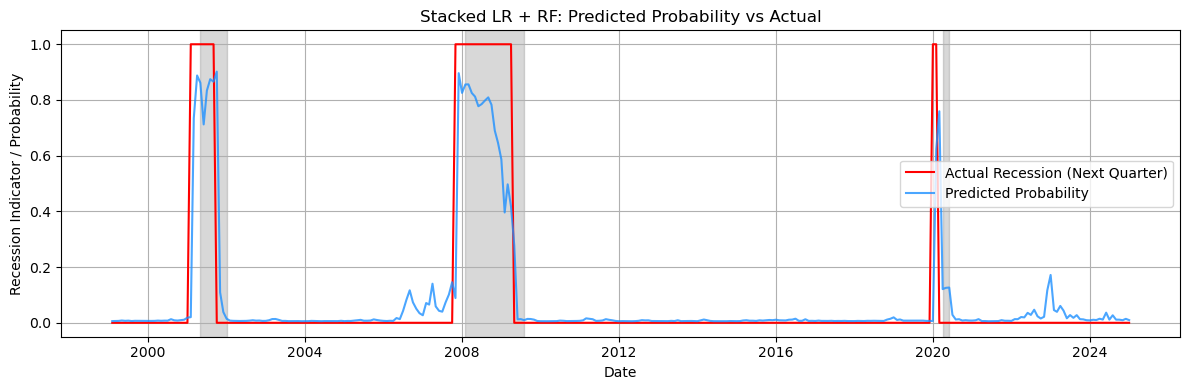

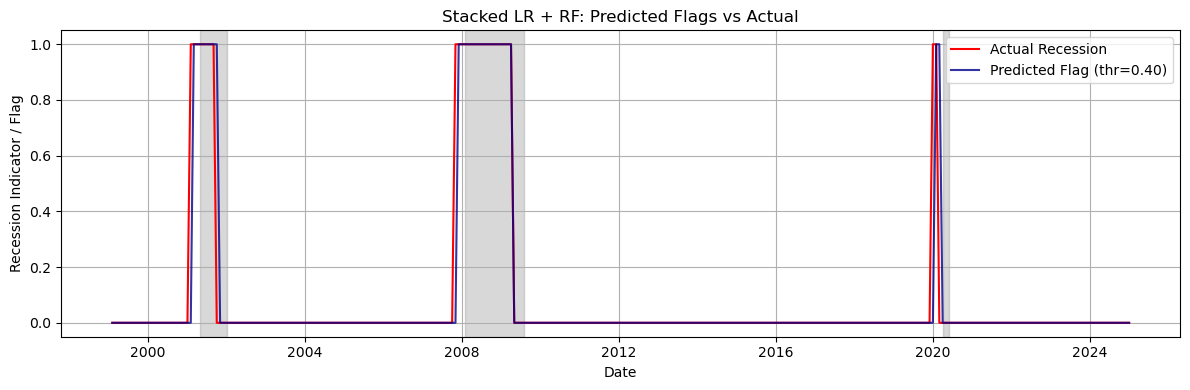

In [117]:
# Fill missing values and add lagged recession flags
X_filled = X.ffill().bfill()
y_filled = y.ffill().bfill()
for lag in (1, 2, 3):
    X_filled[f'recession_lag{lag}'] = y_filled.shift(lag)
X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# Standardize features
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)

# Chronological train/validation split (60/40)
n = len(X_scaled_df)
train_end = int(n * 0.6)
X_train = X_scaled_df.iloc[:train_end]
X_val   = X_scaled_df.iloc[train_end:]
y_train = y_filled.iloc[:train_end]
y_val   = y_filled.iloc[train_end:]

# Pipeline: SMOTE + L1-regularized logistic, tuned with time-series CV
tscv = TimeSeriesSplit(n_splits=5)
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('lr',    LogisticRegression(class_weight='balanced',
                                 max_iter=2000,
                                 random_state=42))
])
param_grid = {
    'lr__C':       [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1'],
    'lr__solver':  ['liblinear']
}
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=tscv,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Extract best logistic from pipeline
best_lr = grid.best_estimator_.named_steps['lr']

# SMOTE over-sampling on full training set for stacking
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train stacking classifier with logistic + RF base learners
base_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced_subsample',
    random_state=42
)
stack_clf = StackingClassifier(
    estimators=[('lr', best_lr), ('rf', base_rf)],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,
    n_jobs=-1
)
stack_clf.fit(X_res, y_res)

# Predict probabilities and optimize threshold via PR-curve
probs = stack_clf.predict_proba(X_val)[:, 1]
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores   = 2 * (prec * rec) / (prec + rec)
best_thresh = th[np.nanargmax(f1_scores)]
flags       = (probs >= best_thresh).astype(int)

# Extract and sort logistic coefficients by absolute weight
lr_clf = stack_clf.named_estimators_['lr']
coef = lr_clf.coef_[0]
lr_df = pd.DataFrame({'Feature': X_val.columns, 'Weight': coef})
lr_df['AbsWeight'] = lr_df['Weight'].abs()
lr_df = lr_df.sort_values('AbsWeight', ascending=False).reset_index(drop=True)
top5_lr = lr_df.head(5)[['Feature', 'Weight']].rename(columns={'Weight': 'Weight (signed)'})
bot5_lr = lr_df.tail(5)[['Feature', 'Weight']].rename(columns={'Weight': 'Weight (signed)'})

# Extract and sort RF feature importances
rf_clf = stack_clf.named_estimators_['rf']
rf_df = pd.DataFrame({
    'Feature':    X_val.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)
top5_rf = rf_df.head(5)

# Display top and bottom features
print("### Logistic Regression (top 5 by |weight|)")
print(top5_lr.to_markdown(index=False))
print("\n### Logistic Regression (5 least influential)")
print(bot5_lr.to_markdown(index=False))
print("\n### Random Forest (top 5 by importance)")
print(top5_rf.to_markdown(index=False))

# Plot predicted probability vs actual recession with shading
y_now_trunc = y_now.loc[y_now.index >= y_val.index[0]]
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,               label='Actual Recession (Next Quarter)', color='red')
plt.plot(y_val.index, probs, alpha=0.8,     label='Predicted Probability',           color='dodgerblue')
in_rec = False
rec_start = None
for date, is_rec in y_now_trunc.items():
    if is_rec and not in_rec:
        in_rec = True
        rec_start = date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(rec_start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(rec_start, y_val.index[-1], color='gray', alpha=0.3)
plt.title("Stacked LR + RF: Predicted Probability vs Actual")
plt.xlabel("Date")
plt.ylabel("Recession Indicator / Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot predicted flags vs actual recession with shading
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,   label='Actual Recession',   color='red')
plt.plot(y_val.index, flags,   label=f'Predicted Flag (thr={best_thresh:.2f})', color='darkblue', alpha=0.8)
in_rec = False
rec_start = None
for date, is_rec in y_now_trunc.items():
    if is_rec and not in_rec:
        in_rec = True
        rec_start = date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(rec_start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(rec_start, y_val.index[-1], color='gray', alpha=0.3)
plt.title("Stacked LR + RF: Predicted Flags vs Actual")
plt.xlabel("Date")
plt.ylabel("Recession Indicator / Flag")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [118]:
# Initialize list for model performance metrics
results = []

# --- Baseline Logistic Regression (original features only) ---
orig_feats   = X.columns.tolist()
X_val_base   = X_scaled_df[orig_feats].iloc[train_end:]
probs_lr     = model.predict_proba(X_val_base)[:, 1]
# Compute standard metrics
roc_lr       = roc_auc_score(y_val, probs_lr)
ap_lr        = average_precision_score(y_val, probs_lr)
prec_lr, rec_lr, th_lr = precision_recall_curve(y_val, probs_lr)
f1_lr        = 2 * prec_lr * rec_lr / (prec_lr + rec_lr)
ix_lr        = np.nanargmax(f1_lr)
thr_lr       = th_lr[ix_lr]
flags_lr     = (probs_lr >= thr_lr).astype(int)
# Append metrics including coverage and timing scores
results.append({
    'Model':           'Baseline LR',
    'ROC AUC ↑':       roc_lr,
    'Precision ↑':     prec_lr[ix_lr],
    'Recall ↑':        rec_lr[ix_lr],
    'Best Threshold':  thr_lr,
    'F1 ↑':            f1_lr[ix_lr],
    'Avg Precision ↑': ap_lr,
    'Coverage ↑':      coverage_score(y_val, flags_lr),
    'Timing Score ↑':  compute_timing_score(y_val, flags_lr)
})

# --- LightGBM with SMOTE ---
probs_l = best_lgbm.predict_proba(X_val)[:, 1]
roc_l   = roc_auc_score(y_val, probs_l)
ap_l    = average_precision_score(y_val, probs_l)
prec_l, rec_l, th_l = precision_recall_curve(y_val, probs_l)
f1_l    = 2 * prec_l * rec_l / (prec_l + rec_l)
ix_l    = np.nanargmax(f1_l)
thr_l   = th_l[ix_l]
flags_l = (probs_l >= thr_l).astype(int)
results.append({
    'Model':           'LightGBM + SMOTE',
    'ROC AUC ↑':       roc_l,
    'Precision ↑':     prec_l[ix_l],
    'Recall ↑':        rec_l[ix_l],
    'Best Threshold':  thr_l,
    'F1 ↑':            f1_l[ix_l],
    'Avg Precision ↑': ap_l,
    'Coverage ↑':      coverage_score(y_val, flags_l),
    'Timing Score ↑':  compute_timing_score(y_val, flags_l)
})

# --- LR + RF Ensemble ---
probs_s = stack.predict_proba(X_val)[:, 1]
roc_s   = roc_auc_score(y_val, probs_s)
ap_s    = average_precision_score(y_val, probs_s)
prec_s, rec_s, th_s = precision_recall_curve(y_val, probs_s)
f1_s    = 2 * prec_s * rec_s / (prec_s + rec_s)
ix_s    = np.nanargmax(f1_s)
thr_s   = th_s[ix_s]
flags_s = (probs_s >= thr_s).astype(int)
results.append({
    'Model':           'LR + RF Ensemble',
    'ROC AUC ↑':       roc_s,
    'Precision ↑':     prec_s[ix_s],
    'Recall ↑':        rec_s[ix_s],
    'Best Threshold':  thr_s,
    'F1 ↑':            f1_s[ix_s],
    'Avg Precision ↑': ap_s,
    'Coverage ↑':      coverage_score(y_val, flags_s),
    'Timing Score ↑':  compute_timing_score(y_val, flags_s)
})

# --- LR + RF + SMOTE Ensemble ---
probs_ss = stack_clf.predict_proba(X_val)[:, 1]
roc_ss   = roc_auc_score(y_val, probs_ss)
ap_ss    = average_precision_score(y_val, probs_ss)
prec_ss, rec_ss, th_ss = precision_recall_curve(y_val, probs_ss)
f1_ss    = 2 * prec_ss * rec_ss / (prec_ss + rec_ss)
ix_ss    = np.nanargmax(f1_ss)
thr_ss   = th_ss[ix_ss]
flags_ss = (probs_ss >= thr_ss).astype(int)
results.append({
    'Model':           'LR + RF + SMOTE Ensemble',
    'ROC AUC ↑':       roc_ss,
    'Precision ↑':     prec_ss[ix_ss],
    'Recall ↑':        rec_ss[ix_ss],
    'Best Threshold':  thr_ss,
    'F1 ↑':            f1_ss[ix_ss],
    'Avg Precision ↑': ap_ss,
    'Coverage ↑':      coverage_score(y_val, flags_ss),
    'Timing Score ↑':  compute_timing_score(y_val, flags_ss)
})

# Build and display comparison table
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

C:\Users\User\AppData\Local\Temp\ipykernel_11528\2360805159.py:76: RuntimeWarning: invalid value encountered in divide
  f1_ss    = 2 * prec_ss * rec_ss / (prec_ss + rec_ss)


ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
Baseline LR                0.947435     0.571429  0.714286        0.045003   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
Baseline LR               0.634921         0.612776    0.486111   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   

                          Timing Score ↑  
Model                                     
Baseline LR                     0.627435  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248  
LR + RF + SMOTE Ensemble        0.684353

### Bi-LSTM Followed by Hyperparameter Grid Search

In [120]:
class AdvancedBiLSTM(nn.Module):
    """
    Enhanced bidirectional LSTM with layer normalization, self-attention,
    and combined pooling (attention + mean + max) for richer context.
    """
    def __init__(self, n_features, hidden, num_layers=4, dropout=0.1, bidirectional=True):
        super().__init__()
        # Bidirectional LSTM with optional dropout between layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        # Normalize LSTM outputs across feature dimension
        self.layer_norm = nn.LayerNorm(hidden * 2)
        # Linear layer to compute attention scores
        self.attn_fc     = nn.Linear(hidden * 2, 1)
        # Dense layer for classification head
        self.fc1         = nn.Linear(hidden * 2, hidden)
        self.dropout     = nn.Dropout(dropout)
        # Final linear layer producing a single logit
        self.fc2         = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, _ = self.lstm(x)                         # (batch, seq_len, 2*hidden)
        out     = self.layer_norm(out)

        # Self-attention pooling
        attn_scores  = self.attn_fc(out)              # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context_attn = torch.sum(attn_weights * out, dim=1)  # (batch, 2*hidden)

        # Global mean and max pooling
        context_mean, _ = torch.mean(out, dim=1), None
        context_max, _  = torch.max(out, dim=1)

        # Combine pooled contexts
        context = context_attn + context_mean + context_max  # (batch, 2*hidden)

        # Classification head
        h = F.relu(self.fc1(context))
        h = self.dropout(h)
        logits = self.fc2(h).squeeze(1)               # (batch,)
        return logits


# Early stopping patience and device configuration
PATIENCE = 10
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"


# Fill missing data in features and target
X_filled = X.ffill().bfill()
y_filled = y.ffill().bfill()

# Add lagged recession flag (3-month shift)
X_filled[f"recession_lag{lag}"] = y_filled.shift(3)

# Replace infinities and refill missing values
X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# Standardize features to zero mean and unit variance
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)

# Chronological train/validation split (60/40)
n_total   = len(X_scaled_df)
train_end = int(n_total * 0.6)
val_start = train_end
val_end   = n_total


def make_sequences(Xmat, yvec, start, end, window):
    # Build rolling window sequences for LSTM input
    seq_X, seq_y = [], []
    for i in range(start, end - window + 1):
        seq_X.append(Xmat.iloc[i : i + window].values)
        seq_y.append(yvec.iloc[i + window - 1])
    return (
        torch.tensor(np.stack(seq_X), dtype=torch.float32),
        torch.tensor(np.stack(seq_y), dtype=torch.float32),
    )


class SeqDataset(Dataset):
    # PyTorch Dataset for sequence data
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [121]:
# Training configuration and device selection
EPOCHS   = 200
PATIENCE = 14
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameter grid including window size
param_grid = {
    'window':     [3],
    'hidden':     [64, 128],
    'n_layers':   [8, 6],
    'dropout':    [0.2, 0.1],
    'lr':         [1e-4, 3e-4, 1e-3],
    'batch_size': [16, 32],
}

# Compute total number of grid trials for progress display
from math import prod
total_trials = prod(len(v) for v in param_grid.values())

# Initialize trackers for best validation loss, params, and model state
best_val_loss = math.inf
best_params   = None
best_state    = None
trial_counter = 0

# Grid search over hyperparameters
for window in param_grid['window']:
    # Rebuild sequences for this window
    X_seq, y_seq = make_sequences(X_scaled_df, y_filled, 0, len(X_scaled_df), window)
    split = int(len(X_seq) * 0.6)
    X_train_t, y_train_t = X_seq[:split], y_seq[:split]
    X_val_t,   y_val_t   = X_seq[split:], y_seq[split:]

    for hidden, n_layers, dropout, lr, batch_size in product(
            param_grid['hidden'],
            param_grid['n_layers'],
            param_grid['dropout'],
            param_grid['lr'],
            param_grid['batch_size']
        ):
        trial_counter += 1

        # Create DataLoaders without shuffling to preserve time order
        train_loader = DataLoader(
            SeqDataset(X_train_t, y_train_t),
            batch_size=batch_size, shuffle=False
        )
        val_loader = DataLoader(
            SeqDataset(X_val_t,   y_val_t),
            batch_size=batch_size, shuffle=False
        )

        # Initialize model, loss function with class weighting, and optimizer
        model = AdvancedBiLSTM(
            n_features = X_train_t.shape[2],
            hidden     = hidden,
            num_layers = n_layers,
            dropout    = dropout
        ).to(DEVICE)
        pos_weight = (len(y_train_t) - y_train_t.sum()) / y_train_t.sum()
        criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))
        optimizer  = optim.Adam(model.parameters(), lr=lr)

        # Track best training and validation loss in this trial
        local_best_val   = math.inf
        local_best_train = math.inf
        patience         = 0

        # Epoch loop with progress bar
        for epoch in tqdm(
                range(1, 51),
                desc=f"Trial {trial_counter}/{total_trials}",
                leave=False
            ):
            # Training step
            model.train()
            train_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb.size(0)
            train_loss /= len(train_loader.dataset)

            # Validation step
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    val_loss += criterion(model(xb), yb).item() * xb.size(0)
            val_loss /= len(val_loader.dataset)

            # Early stopping based on validation loss
            if val_loss < local_best_val:
                local_best_val   = val_loss
                local_best_train = train_loss
                patience         = 0
            else:
                patience += 1
                if patience >= 5:
                    break

        # Log trial results
        tqdm.write(
            f"Trial {trial_counter}/{total_trials} "
            f"(w={window}, h={hidden}, layers={n_layers}, do={dropout}, lr={lr}, bs={batch_size}): "
            f"best_train={local_best_train:.4f}, best_val={local_best_val:.4f}"
        )

        # Update global best if this trial improved validation loss
        if local_best_val < best_val_loss:
            best_val_loss = local_best_val
            best_params   = {
                'window':     window,
                'hidden':     hidden,
                'n_layers':   n_layers,
                'dropout':    dropout,
                'lr':         lr,
                'batch_size': batch_size
            }
            best_state    = deepcopy(model.state_dict())

# Report best validation loss and corresponding hyperparameters
print("Best validation loss:", best_val_loss)
print("Best hyperparameters:", best_params)

# Reload the best model state for final evaluation
model_best = AdvancedBiLSTM(
    n_features = X_train_t.shape[2],
    hidden     = best_params['hidden'],
    num_layers = best_params['n_layers'],
    dropout    = best_params['dropout']
).to(DEVICE)
model_best.load_state_dict(best_state)

Trial 1/48 (w=3, h=64, layers=8, do=0.2, lr=0.0001, bs=16): best_train=0.4287, best_val=0.4388


Trial 2/48 (w=3, h=64, layers=8, do=0.2, lr=0.0001, bs=32): best_train=0.3483, best_val=0.4312


Trial 3/48 (w=3, h=64, layers=8, do=0.2, lr=0.0003, bs=16): best_train=0.4475, best_val=0.4787


Trial 4/48 (w=3, h=64, layers=8, do=0.2, lr=0.0003, bs=32): best_train=0.6336, best_val=0.4564


Trial 5/48 (w=3, h=64, layers=8, do=0.2, lr=0.001, bs=16): best_train=0.6214, best_val=0.5056


Trial 6/48 (w=3, h=64, layers=8, do=0.2, lr=0.001, bs=32): best_train=0.4104, best_val=0.4299


Trial 7/48 (w=3, h=64, layers=8, do=0.1, lr=0.0001, bs=16): best_train=0.3999, best_val=0.4230


Trial 8/48 (w=3, h=64, layers=8, do=0.1, lr=0.0001, bs=32): best_train=0.3401, best_val=0.4111


Trial 9/48 (w=3, h=64, layers=8, do=0.1, lr=0.0003, bs=16): best_train=0.3590, best_val=0.4989


Trial 10/48 (w=3, h=64, layers=8, do=0.1, lr=0.0003, bs=32): best_train=0.4526, best_val=0.4269


Trial 11/48 (w=3, h=64, layers=8, do=0.1, lr=0.001, bs=16): best_train=0.6589, best_val=0.4491


Trial 12/48 (w=3, h=64, layers=8, do=0.1, lr=0.001, bs=32): best_train=0.6509, best_val=0.5303


Trial 13/48 (w=3, h=64, layers=6, do=0.2, lr=0.0001, bs=16): best_train=0.4245, best_val=0.4241


Trial 14/48 (w=3, h=64, layers=6, do=0.2, lr=0.0001, bs=32): best_train=0.3836, best_val=0.4433


Trial 15/48 (w=3, h=64, layers=6, do=0.2, lr=0.0003, bs=16): best_train=0.7889, best_val=0.4008


Trial 16/48 (w=3, h=64, layers=6, do=0.2, lr=0.0003, bs=32): best_train=0.4119, best_val=0.4603


Trial 17/48 (w=3, h=64, layers=6, do=0.2, lr=0.001, bs=16): best_train=0.8183, best_val=0.5144


Trial 18/48 (w=3, h=64, layers=6, do=0.2, lr=0.001, bs=32): best_train=0.4536, best_val=0.4870


Trial 19/48 (w=3, h=64, layers=6, do=0.1, lr=0.0001, bs=16): best_train=0.3999, best_val=0.4369


Trial 20/48 (w=3, h=64, layers=6, do=0.1, lr=0.0001, bs=32): best_train=0.3770, best_val=0.4675


Trial 21/48 (w=3, h=64, layers=6, do=0.1, lr=0.0003, bs=16): best_train=0.5776, best_val=0.4430


Trial 22/48 (w=3, h=64, layers=6, do=0.1, lr=0.0003, bs=32): best_train=0.5175, best_val=0.4065


Trial 23/48 (w=3, h=64, layers=6, do=0.1, lr=0.001, bs=16): best_train=0.5095, best_val=0.5258


Trial 24/48 (w=3, h=64, layers=6, do=0.1, lr=0.001, bs=32): best_train=0.5397, best_val=0.4608


Trial 25/48 (w=3, h=128, layers=8, do=0.2, lr=0.0001, bs=16): best_train=0.4273, best_val=0.4423


Trial 26/48 (w=3, h=128, layers=8, do=0.2, lr=0.0001, bs=32): best_train=0.5779, best_val=0.4341


Trial 27/48 (w=3, h=128, layers=8, do=0.2, lr=0.0003, bs=16): best_train=0.4501, best_val=0.5214


Trial 28/48 (w=3, h=128, layers=8, do=0.2, lr=0.0003, bs=32): best_train=0.5762, best_val=0.4451


Trial 29/48 (w=3, h=128, layers=8, do=0.2, lr=0.001, bs=16): best_train=0.6225, best_val=0.6460


Trial 30/48 (w=3, h=128, layers=8, do=0.2, lr=0.001, bs=32): best_train=0.6750, best_val=0.4534


Trial 31/48 (w=3, h=128, layers=8, do=0.1, lr=0.0001, bs=16): best_train=0.4493, best_val=0.4612


Trial 32/48 (w=3, h=128, layers=8, do=0.1, lr=0.0001, bs=32): best_train=0.4541, best_val=0.4292


Trial 33/48 (w=3, h=128, layers=8, do=0.1, lr=0.0003, bs=16): best_train=0.3534, best_val=0.4639


Trial 34/48 (w=3, h=128, layers=8, do=0.1, lr=0.0003, bs=32): best_train=0.4815, best_val=0.5081


Trial 35/48 (w=3, h=128, layers=8, do=0.1, lr=0.001, bs=16): best_train=1.0688, best_val=0.6648


Trial 36/48 (w=3, h=128, layers=8, do=0.1, lr=0.001, bs=32): best_train=0.7171, best_val=0.4257


Trial 37/48 (w=3, h=128, layers=6, do=0.2, lr=0.0001, bs=16): best_train=0.6446, best_val=0.4778


Trial 38/48 (w=3, h=128, layers=6, do=0.2, lr=0.0001, bs=32): best_train=0.4210, best_val=0.4396


Trial 39/48 (w=3, h=128, layers=6, do=0.2, lr=0.0003, bs=16): best_train=1.0521, best_val=0.5123


Trial 40/48 (w=3, h=128, layers=6, do=0.2, lr=0.0003, bs=32): best_train=0.6583, best_val=0.4715


Trial 41/48 (w=3, h=128, layers=6, do=0.2, lr=0.001, bs=16): best_train=0.7887, best_val=0.5234


Trial 42/48 (w=3, h=128, layers=6, do=0.2, lr=0.001, bs=32): best_train=0.3108, best_val=0.4923


Trial 43/48 (w=3, h=128, layers=6, do=0.1, lr=0.0001, bs=16): best_train=0.3912, best_val=0.4292


Trial 44/48 (w=3, h=128, layers=6, do=0.1, lr=0.0001, bs=32): best_train=0.3957, best_val=0.4567


Trial 45/48 (w=3, h=128, layers=6, do=0.1, lr=0.0003, bs=16): best_train=0.3474, best_val=0.4953


Trial 46/48 (w=3, h=128, layers=6, do=0.1, lr=0.0003, bs=32): best_train=0.5219, best_val=0.4413


Trial 47/48 (w=3, h=128, layers=6, do=0.1, lr=0.001, bs=16): best_train=0.4404, best_val=0.5764


Trial 48/48 (w=3, h=128, layers=6, do=0.1, lr=0.001, bs=32): best_train=0.8811, best_val=0.4403
Best validation loss: 0.40079941619665194
Best hyperparameters: {'window': 3, 'hidden': 64, 'n_layers': 6, 'dropout': 0.2, 'lr': 0.0003, 'batch_size': 16}


<All keys matched successfully>

C:\Users\User\AppData\Local\Temp\ipykernel_11528\118245226.py:9: RuntimeWarning: invalid value encountered in divide
  f1_b = 2 * (prec_b * rec_b) / (prec_b + rec_b)


ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
Baseline LR                0.947435     0.571429  0.714286        0.045003   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   
Best BiLSTM                0.949195     0.766667  0.821429        0.723544   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
Baseline LR               0.634921         0.612776    0.486111   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   
Best BiLSTM               0.793103         0.654072    0.541667   

                          Timing Score ↑  
Model                                     
Baseline LR                     0.627435  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248  
LR + RF + SMOTE Ensemble        0.684353  
Best BiLSTM                     0.642103

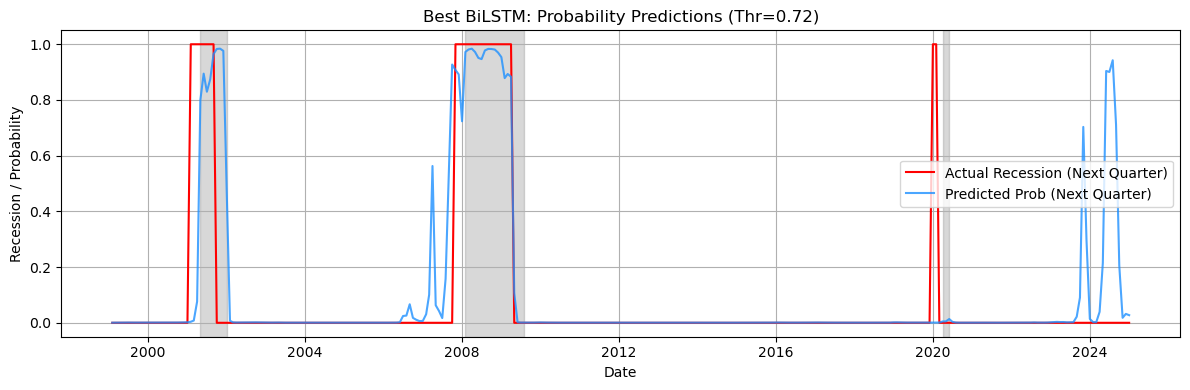

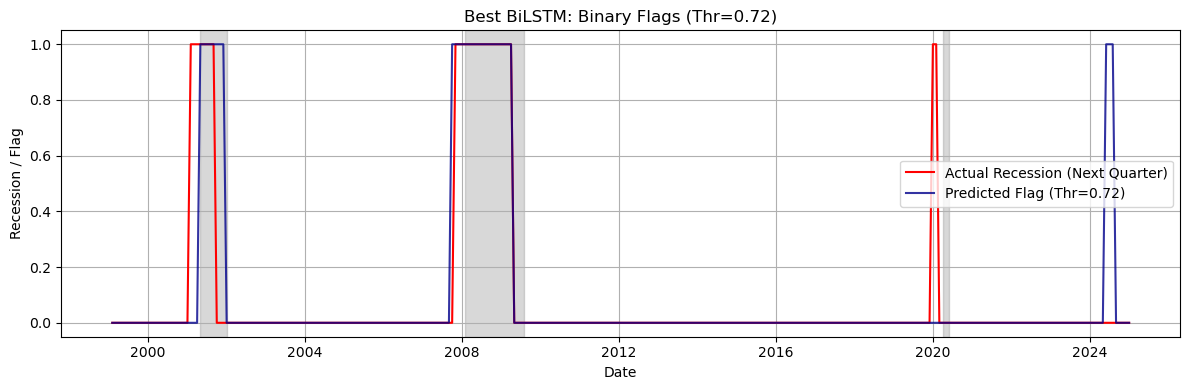

In [122]:
# Compute validation probabilities from LSTM
model_best.to(DEVICE).eval()
with torch.no_grad():
    logits_val = model_best(X_val_t.to(DEVICE))
probs_b = torch.sigmoid(logits_val).cpu().numpy()

# Find best threshold via Precision–Recall
prec_b, rec_b, th_b = precision_recall_curve(y_val, probs_b)
f1_b = 2 * (prec_b * rec_b) / (prec_b + rec_b)
ix_b = np.nanargmax(f1_b)
thr_b = th_b[ix_b]

# Binarize at the optimal threshold
flags_b = (probs_b >= thr_b).astype(int)

# Compute metrics
roc_b = roc_auc_score(y_val, probs_b)
ap_b  = average_precision_score(y_val, probs_b)

results.append({
    'Model':           'Best BiLSTM',
    'ROC AUC ↑':       roc_b,
    'Precision ↑':     prec_b[ix_b],
    'Recall ↑':        rec_b[ix_b],
    'Best Threshold':  thr_b,
    'F1 ↑':            f1_b[ix_b],
    'Avg Precision ↑': ap_b,
    'Coverage ↑':      coverage_score(y_val, flags_b),
    'Timing Score ↑':  compute_timing_score(y_val.values, flags_b)
})

# Build and display comparison table
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

# Define validation date index for plotting
n_val     = len(probs_b)
dates_val = X_scaled_df.index[train_end : train_end + n_val]
y_now_val = y_now.loc[dates_val]

# Probability plot
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val], color='red',
         label='Actual Recession (Next Quarter)')
plt.plot(dates_val, probs_b, color='dodgerblue', alpha=0.8,
         label='Predicted Prob (Next Quarter)')
in_rec = False
for date, is_rec in y_now_val.items():
    if is_rec and not in_rec:
        in_rec, start = True, date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(start, dates_val[-1], color='gray', alpha=0.3)
plt.title(f"Best BiLSTM: Probability Predictions (Thr={thr_b:.2f})")
plt.xlabel("Date"); plt.ylabel("Recession / Probability")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Flag plot
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val], color='red',
         label='Actual Recession (Next Quarter)')
plt.plot(dates_val, flags_b, color='darkblue', alpha=0.8,
         label=f'Predicted Flag (Thr={thr_b:.2f})')
in_rec = False
for date, is_rec in y_now_val.items():
    if is_rec and not in_rec:
        in_rec, start = True, date
    elif not is_rec and in_rec:
        in_rec = False
        plt.axvspan(start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(start, dates_val[-1], color='gray', alpha=0.3)
plt.title(f"Best BiLSTM: Binary Flags (Thr={thr_b:.2f})")
plt.xlabel("Date"); plt.ylabel("Recession / Flag")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

### SVD Followed by the same Bi-LSTM

In [124]:
# Define sequence window length
WINDOW = 3
# Generate sliding window sequences
X_seq, y_seq = make_sequences(X_scaled_df, y_filled, 0, len(X_scaled_df), WINDOW)

# Reshape for flat matrix: (n_samples, window * n_features)
n_samples, window, n_feat = X_seq.shape
X_flat = X_seq.reshape(n_samples, window * n_feat)
# Center data by subtracting feature means
means = X_flat.mean(axis=0, keepdims=True)
Xc = X_flat - means

In [125]:
# Retrieve the total number of elements in the centered data matrix
Xc.size()

torch.Size([778, 111])

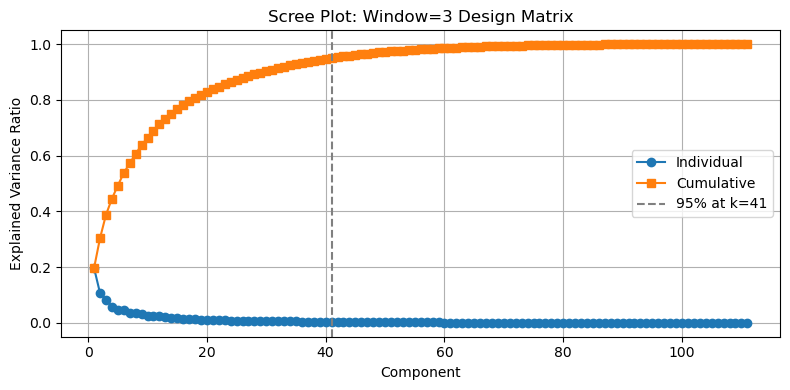

In [126]:
# Perform SVD on centered data matrix
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

# Compute variance explained by each singular value
explained = S**2 / np.sum(S**2)
cum_explained = np.cumsum(explained)

# Identify number of components to reach 95% cumulative variance
k95 = np.searchsorted(cum_explained, 0.95) + 1

# Scree plot of explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(S) + 1), explained, 'o-', label='Individual')
plt.plot(np.arange(1, len(S) + 1), cum_explained, 's-', label='Cumulative')
plt.axvline(k95, color='gray', linestyle='--', label=f'95% at k={k95}')
plt.title("Scree Plot: Window=3 Design Matrix")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
# Set sequence window and generate data sequences
WINDOW = 3
X_seq, y_seq = make_sequences(X_scaled_df, y_filled, 0, len(X_scaled_df), WINDOW)
n_samples, _, n_features = X_seq.shape

# Flatten sequences and center by subtracting feature means
X_flat = X_seq.reshape(n_samples, WINDOW * n_features)
means  = X_flat.mean(axis=0, keepdims=True)
Xc     = X_flat - means

# Perform SVD and select k components for 95% explained variance
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
explained     = S**2 / np.sum(S**2)
cum_explained = np.cumsum(explained)
k             = np.searchsorted(cum_explained, 0.95) + 1

# Reconstruct approximate design matrix using top k components
Uk            = U[:, :k]
Sk            = np.diag(S[:k])
Vtk           = Vt[:k, :]
X_flat_approx = (Uk @ Sk) @ Vtk + means

# Reshape back to sequences and convert targets to tensor
X_seq_approx = X_flat_approx.reshape(n_samples, WINDOW, n_features)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Split sequences chronologically into train/validation sets (60/40)
split        = int(n_samples * 0.6)
X_train_app  = torch.tensor(X_seq_approx[:split], dtype=torch.float32)
y_train_app  = y_seq_tensor[:split]
X_val_app    = torch.tensor(X_seq_approx[split:], dtype=torch.float32)
y_val_app    = y_seq_tensor[split:]

# Create DataLoaders without shuffling to preserve sequence order
batch_size   = 32  # from best hyperparameters
train_loader = DataLoader(SeqDataset(X_train_app, y_train_app),
                          batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(SeqDataset(X_val_app,   y_val_app),
                          batch_size=batch_size, shuffle=False)

# Initialize best-model architecture with selected hyperparameters
hidden    = 64
n_layers  = 8
dropout   = 0.15
lr        = 1e-4
model_app = AdvancedBiLSTM(n_features=n_features,
                           hidden=hidden,
                           num_layers=n_layers,
                           dropout=dropout,
                           bidirectional=True).to(DEVICE)

# Define weighted binary cross-entropy loss and Adam optimizer
pos_weight = (len(y_train_app) - y_train_app.sum()) / y_train_app.sum()
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))
optimizer  = optim.Adam(model_app.parameters(), lr=lr)

# Train with early stopping based on validation loss
best_val, patience = float('inf'), 0
for epoch in range(1, 201):
    # Training step
    model_app.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_app(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation step
    model_app.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            val_loss += criterion(model_app(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:3d} — train {train_loss:.4f}  val {val_loss:.4f}")

    # Check for improvement or early stop
    if val_loss < best_val:
        best_val, patience = val_loss, 0
        torch.save(model_app.state_dict(), "bilstm_app_best.pt")
    else:
        patience += 1
        if patience >= 10:
            print("Early stopping")
            break

# Load saved best model and report validation loss
model_app.load_state_dict(torch.load("bilstm_app_best.pt"))
print("Best validation loss on approximated design:", best_val)

C:\Users\User\AppData\Local\Temp\ipykernel_11528\1381470002.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_flat_approx = (Uk @ Sk) @ Vtk + means
C:\Users\User\AppData\Local\Temp\ipykernel_11528\1381470002.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_11528\1381470002.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_app  = torch.tensor(X_seq_approx[:split], dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_11528\1381470002.py:31: UserWarning: To copy construct 

Epoch   1 — train 1.2464  val 1.0643
Epoch   2 — train 1.1973  val 1.0026
Epoch   3 — train 1.1868  val 0.9947
Epoch   4 — train 1.2026  val 0.9967
Epoch   5 — train 1.2159  val 1.0017
Epoch   6 — train 1.2100  val 1.0009
Epoch   7 — train 1.2202  val 1.0004
Epoch   8 — train 1.1635  val 0.9891
Epoch   9 — train 1.1434  val 0.9558
Epoch  10 — train 1.1042  val 0.8708
Epoch  11 — train 0.8944  val 0.6840
Epoch  12 — train 0.6469  val 0.5204
Epoch  13 — train 0.4880  val 0.4456
Epoch  14 — train 0.3965  val 0.4230
Epoch  15 — train 0.3573  val 0.4297
Epoch  16 — train 0.3264  val 0.4452
Epoch  17 — train 0.3024  val 0.4532
Epoch  18 — train 0.2693  val 0.4627
Epoch  19 — train 0.2525  val 0.4762
Epoch  20 — train 0.2311  val 0.4913
Epoch  21 — train 0.2109  val 0.5090
Epoch  22 — train 0.1941  val 0.5331
Epoch  23 — train 0.1664  val 0.5635
Epoch  24 — train 0.1707  val 0.5831
Early stopping
Best validation loss on approximated design: 0.4230328515554086


In [128]:
# Set model to evaluation mode
model_app.eval()

# Get validation predictions
with torch.no_grad():
    logits_app = model_app(X_val_app.to(DEVICE))        # (n_val_samples,)
probs_app = torch.sigmoid(logits_app).cpu().numpy()     # probabilities

# Align true labels with validation period
y_val = y.iloc[train_end:]

# Compute precision–recall curve and select best F1 threshold
prec_app, rec_app, th_app = precision_recall_curve(y_val, probs_app)
f1_app = 2 * (prec_app * rec_app) / (prec_app + rec_app)
ix_app = np.nanargmax(f1_app)
thr_app = th_app[ix_app]

# Binarize at that threshold
flags_app = (probs_app >= thr_app).astype(int)

# Compute evaluation metrics
roc_app = roc_auc_score(y_val, probs_app)
ap_app  = average_precision_score(y_val, probs_app)

# Append PCA + BiLSTM results to comparison list
results.append({
    'Model':           'PCA + BiLSTM',
    'ROC AUC ↑':       roc_app,
    'Precision ↑':     prec_app[ix_app],
    'Recall ↑':        rec_app[ix_app],
    'Best Threshold':  thr_app,
    'F1 ↑':            f1_app[ix_app],
    'Avg Precision ↑': ap_app,
    'Coverage ↑':      coverage_score(y_val, flags_app),
    'Timing Score ↑':  compute_timing_score(y_val.values, flags_app)
})

# Re-display the comparison table
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
Baseline LR                0.947435     0.571429  0.714286        0.045003   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   
Best BiLSTM                0.949195     0.766667  0.821429        0.723544   
PCA + BiLSTM               0.927817     0.657143  0.821429        0.793691   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
Baseline LR               0.634921         0.612776    0.486111   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   
Best BiLSTM               0.793103         0.654072    0.541667   
PCA + BiLSTM              0.730159         0.767498    0.541667   

                          Timing Score ↑  
Model                                     
Baseline LR                     0.627435  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248  
LR + RF + SMOTE Ensemble        0.684353  
Best BiLSTM                     0.642103  
PCA + BiLSTM                    0.596544

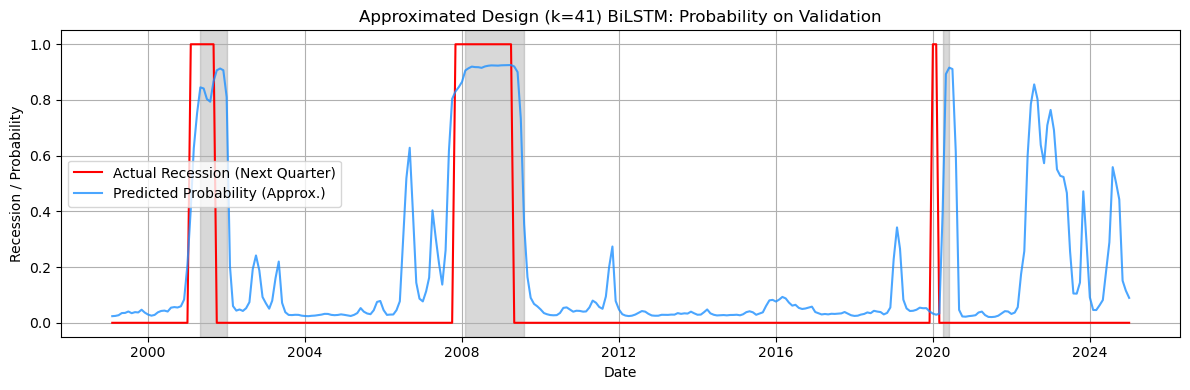

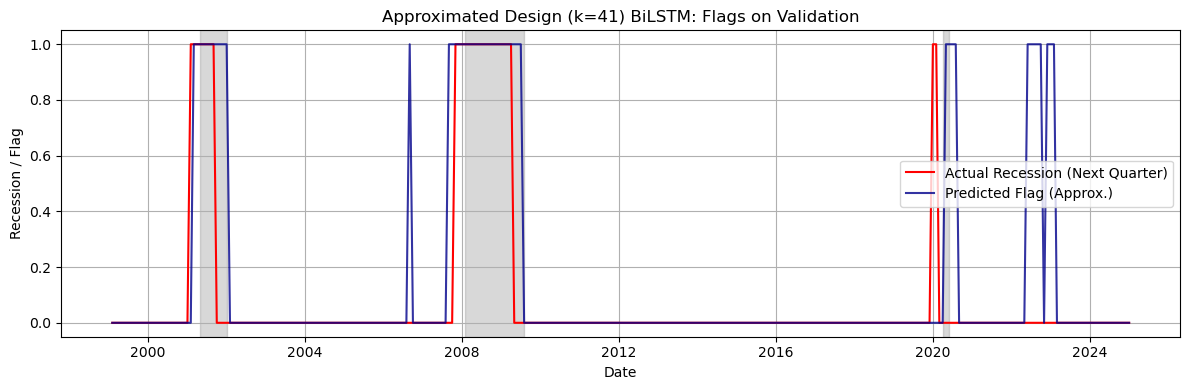

In [129]:
# Set model to evaluation mode
model_app.eval()

# Generate validation probabilities and binary flags at threshold 0.6
with torch.no_grad():
    logits_app = model_app(X_val_app.to(DEVICE))        # (n_val_samples,)
probs_app = torch.sigmoid(logits_app).cpu().numpy()     # probabilities
flags_app = (probs_app >= 0.6).astype(int)              # binary flags

# Build date index aligned to sequence window ends
idx = X_scaled_df.index
dates_val = idx[split + WINDOW - 1 : split + WINDOW - 1 + len(probs_app)]

# Truncate true recession series for shading
y_now_val = y_now.loc[dates_val]

# Plot probability predictions vs actual recession with shading
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val],
         label='Actual Recession (Next Quarter)', color='red')
plt.plot(dates_val, probs_app,
         label='Predicted Probability (Approx.)', color='dodgerblue', alpha=0.8)

# Shade true recession periods
in_rec, start = False, None
for date, rec in y_now_val.items():
    if rec and not in_rec:
        in_rec, start = True, date
    elif not rec and in_rec:
        in_rec = False
        plt.axvspan(start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(start, dates_val[-1], color='gray', alpha=0.3)

plt.title(f"Approximated Design (k={k}) BiLSTM: Probability on Validation")
plt.xlabel("Date")
plt.ylabel("Recession / Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save probability plot
plt.savefig(
    f"10- Approximated Design (k={k}) BiLSTM - Probability on Validation.png",
    dpi=600, bbox_inches='tight'
)
plt.show()

# Plot binary flag predictions vs actual recession with shading
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val],
         label='Actual Recession (Next Quarter)', color='red')
plt.plot(dates_val, flags_app,
         label='Predicted Flag (Approx.)', color='darkblue', alpha=0.8)

# Shade true recession periods
in_rec, start = False, None
for date, rec in y_now_val.items():
    if rec and not in_rec:
        in_rec, start = True, date
    elif not rec and in_rec:
        in_rec = False
        plt.axvspan(start, date, color='gray', alpha=0.3)
if in_rec:
    plt.axvspan(start, dates_val[-1], color='gray', alpha=0.3)

plt.title(f"Approximated Design (k={k}) BiLSTM: Flags on Validation")
plt.xlabel("Date")
plt.ylabel("Recession / Flag")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save flag plot
plt.savefig(
    f"11- Approximated Design (k={k}) BiLSTM - Flags on Validation.png",
    dpi=600, bbox_inches='tight'
)
plt.show()

### ARIMAX

In [131]:
# Generate sliding-window sequences (window=3)
X_seq, y_seq = make_sequences(X_scaled_df, y_filled, 0, len(X_scaled_df), 3)

# Compute split index for 60/40 train/validation
split = int(len(X_seq) * 0.6)

# Split sequences into training and validation sets
X_train_t, y_train_t = X_seq[:split], y_seq[:split]
X_val_t,   y_val_t   = X_seq[split:], y_seq[split:]

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_11528\315625063.py:39: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * prec * rec / (prec + rec)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_11528\315625063.py:39: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * prec * rec / (prec + rec)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\U

→ Best ARIMAX order=(0, 0, 1), F1=0.278, thr=0.146


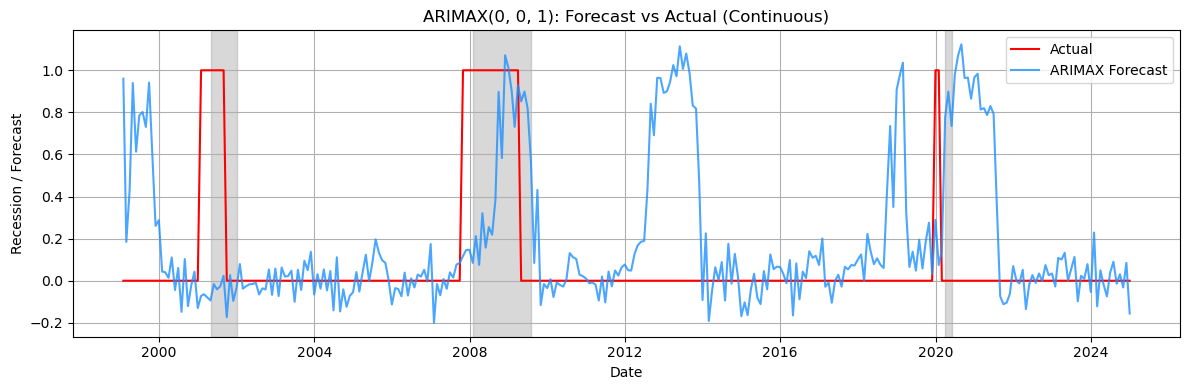

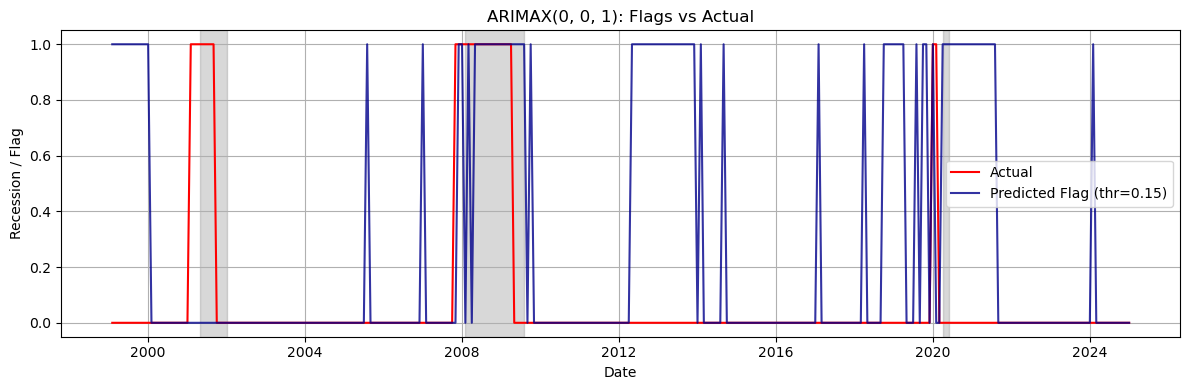

C:\Users\User\AppData\Local\Temp\ipykernel_11528\315625063.py:97: RuntimeWarning: invalid value encountered in divide
  ix = np.nanargmax(2 * prec * rec / (prec + rec))


ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
Baseline LR                0.947435     0.571429  0.714286        0.045003   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   
Best BiLSTM                0.949195     0.766667  0.821429        0.723544   
PCA + BiLSTM               0.927817     0.657143  0.821429        0.793691   
ARIMAX(0, 0, 1)            0.627892     0.183908  0.571429        0.146215   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
Baseline LR               0.634921         0.612776    0.486111   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   
Best BiLSTM               0.793103         0.654072    0.541667   
PCA + BiLSTM              0.730159         0.767498    0.541667   
ARIMAX(0, 0, 1)           0.278261         0.144132    0.444444   

                          Timing Score ↑  
Model                                     
Baseline LR                     0.627435  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248  
LR + RF + SMOTE Ensemble        0.684353  
Best BiLSTM                     0.642103  
PCA + BiLSTM                    0.596544  
ARIMAX(0, 0, 1)                 0.583853

In [132]:
# Set window length based on sequence shape
WINDOW = X_seq.shape[1]

# Convert tensors or arrays to numpy
def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

# Prepare numpy arrays for ARIMAX
X_train_np = to_np(X_train_t)
X_val_np   = to_np(X_val_t)
y_train_np = to_np(y_train_t)
y_val_np   = to_np(y_val_t)

# Flatten windows into exogenous feature matrices
n_train, _, n_feats = X_train_np.shape
X_train_exog = X_train_np.reshape(n_train, WINDOW * n_feats)
X_val_exog   = X_val_np.reshape(len(X_val_np), WINDOW * n_feats)

# Build validation date index and recession shading series
idx       = X_scaled_df.index
dates_val = idx[split + WINDOW - 1 : split + WINDOW - 1 + len(y_val_np)]
y_now_val = y_now.loc[dates_val]

# Grid-search ARIMAX(p,d,q) by validation F1 score
best_f1, best_order, best_thr, best_pred = -np.inf, None, None, None
for p, d, q in itertools.product(range(4), range(2), range(4)):
    try:
        model_ar = SARIMAX(
            endog=y_train_np,
            exog=X_train_exog,
            order=(p, d, q),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        y_hat = model_ar.predict(start=0, end=len(y_val_np)-1, exog=X_val_exog)
        prec, rec, th = precision_recall_curve(y_val_np, y_hat)
        f1_scores = 2 * prec * rec / (prec + rec)
        ix = np.nanargmax(f1_scores)
        if f1_scores[ix] > best_f1:
            best_f1, best_order, best_thr, best_pred = (
                f1_scores[ix], (p, d, q), th[ix], y_hat
            )
    except Exception:
        continue

print(f"→ Best ARIMAX order={best_order}, F1={best_f1:.3f}, thr={best_thr:.3f}")

# Generate final forecast and binary flags
y_pred = best_pred
flags  = (y_pred >= best_thr).astype(int)

# Plot continuous forecast vs actual with recession shading
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val], label='Actual', color='red')
plt.plot(dates_val, y_pred, label='ARIMAX Forecast', color='dodgerblue', alpha=0.8)
in_rec, start = False, None
for d, rec in y_now_val.items():
    if rec and not in_rec:
        in_rec, start = True, d
    elif not rec and in_rec:
        in_rec = False
        plt.axvspan(start, d, alpha=0.3, color='gray')
if in_rec:
    plt.axvspan(start, dates_val[-1], alpha=0.3, color='gray')
plt.title(f"ARIMAX{best_order}: Forecast vs Actual (Continuous)")
plt.xlabel("Date"); plt.ylabel("Recession / Forecast")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"12- ARIMAX{best_order}_Forecast.png", dpi=600, bbox_inches='tight')
plt.show()

# Plot binary flags vs actual with shading
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val], label='Actual', color='red')
plt.plot(dates_val, flags, label=f'Predicted Flag (thr={best_thr:.2f})',
         color='darkblue', alpha=0.8)
in_rec, start = False, None
for d, rec in y_now_val.items():
    if rec and not in_rec:
        in_rec, start = True, d
    elif not rec and in_rec:
        in_rec = False
        plt.axvspan(start, d, alpha=0.3, color='gray')
if in_rec:
    plt.axvspan(start, dates_val[-1], alpha=0.3, color='gray')
plt.title(f"ARIMAX{best_order}: Flags vs Actual")
plt.xlabel("Date"); plt.ylabel("Recession / Flag")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"13- ARIMAX{best_order}_Flags.png", dpi=600, bbox_inches='tight')
plt.show()

# Compute evaluation metrics and append to results
roc = roc_auc_score(y_val_np, y_pred)
ap  = average_precision_score(y_val_np, y_pred)
prec, rec, _ = precision_recall_curve(y_val_np, y_pred)
ix = np.nanargmax(2 * prec * rec / (prec + rec))
results.append({
    'Model':           f'ARIMAX{best_order}',
    'ROC AUC ↑':       roc,
    'Precision ↑':     prec[ix],
    'Recall ↑':        rec[ix],
    'Best Threshold':  best_thr,
    'F1 ↑':            best_f1,
    'Avg Precision ↑': ap,
    'Coverage ↑':      coverage_score(y_val_np, flags),
    'Timing Score ↑':  compute_timing_score(y_val_np, flags)
})

# Redisplay comparison table
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

### SVD THEN ARIMAX

In [134]:
# Define sequence window length
WINDOW = 3
# Generate sliding-window sequences
X_seq, y_seq = make_sequences(X_scaled_df, y_filled, 0, len(X_scaled_df), WINDOW)
# Extract sample and feature dimensions
n_samples, _, n_features = X_seq.shape

# Flatten sequences and center by subtracting feature means
X_flat = X_seq.reshape(n_samples, WINDOW * n_features)
means  = X_flat.mean(axis=0, keepdims=True)
Xc     = X_flat - means

# Perform SVD for dimensionality reduction
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
explained     = S**2 / np.sum(S**2)
cum_explained = np.cumsum(explained)
# Determine number of components for 95% variance retention
k = np.searchsorted(cum_explained, 0.95) + 1

# Reconstruct approximate design matrix using top k components
Uk            = U[:, :k]
Sk            = np.diag(S[:k])
Vtk           = Vt[:k, :]
X_flat_approx = (Uk @ Sk) @ Vtk + means

# Reshape back to sequence format and prepare target tensor
X_seq_approx = X_flat_approx.reshape(n_samples, WINDOW, n_features)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Chronological train/validation split (60/40)
split       = int(n_samples * 0.6)
X_train_app = torch.tensor(X_seq_approx[:split], dtype=torch.float32)
y_train_app = y_seq_tensor[:split]
X_val_app   = torch.tensor(X_seq_approx[split:], dtype=torch.float32)
y_val_app   = y_seq_tensor[split:]

C:\Users\User\AppData\Local\Temp\ipykernel_11528\3044244119.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_flat_approx = (Uk @ Sk) @ Vtk + means
C:\Users\User\AppData\Local\Temp\ipykernel_11528\3044244119.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_11528\3044244119.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_app = torch.tensor(X_seq_approx[:split], dtype=torch.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_11528\3044244119.py:34: UserWarning: To copy construct f

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_11528\1193977130.py:40: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * prec * rec / (prec + rec)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_11528\1193977130.py:40: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * prec * rec / (prec + rec)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:

→ Best ARIMAX order=(2, 0, 3), F1=0.265, thr=0.165


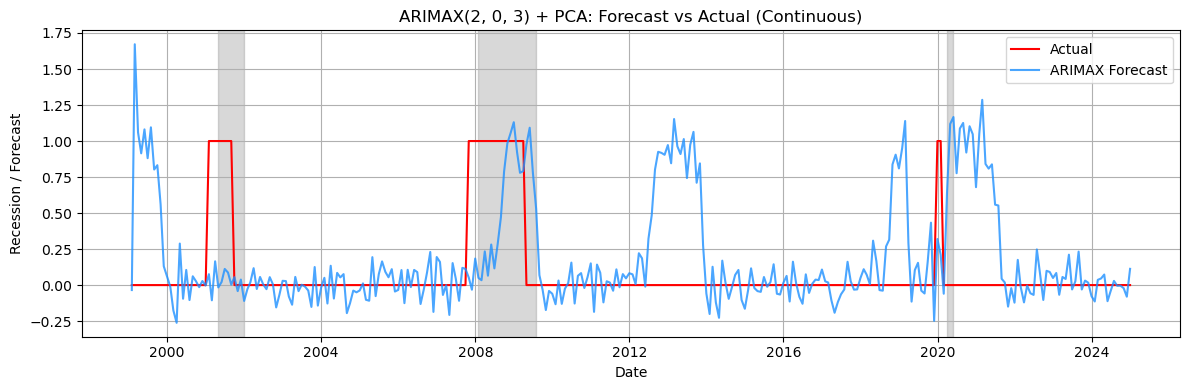

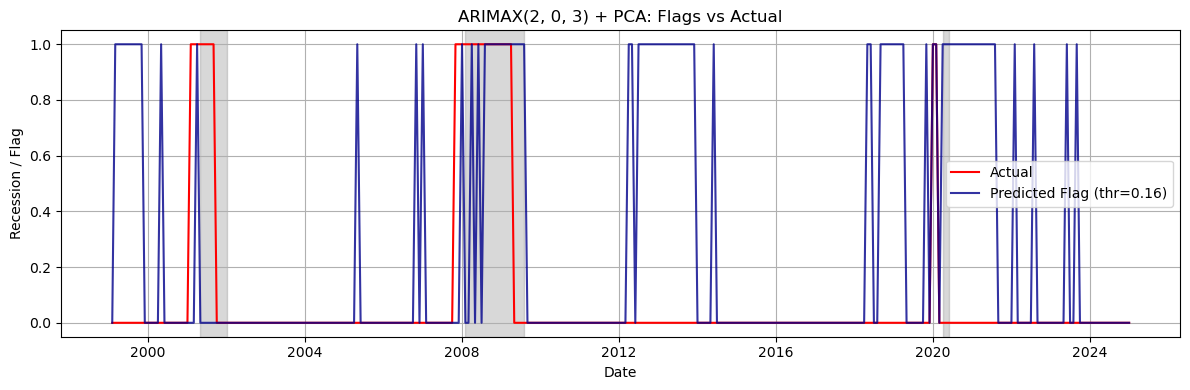

C:\Users\User\AppData\Local\Temp\ipykernel_11528\1193977130.py:104: RuntimeWarning: invalid value encountered in divide
  ix = np.nanargmax(2 * prec * rec / (prec + rec))


ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
Baseline LR                0.947435     0.571429  0.714286        0.045003   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   
Best BiLSTM                0.949195     0.766667  0.821429        0.723544   
PCA + BiLSTM               0.927817     0.657143  0.821429        0.793691   
ARIMAX(0, 0, 1)            0.627892     0.183908  0.571429        0.146215   
ARIMAX(2, 0, 3) + PCA      0.679200     0.176471  0.535714        0.164999   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
Baseline LR               0.634921         0.612776    0.486111   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   
Best BiLSTM               0.793103         0.654072    0.541667   
PCA + BiLSTM              0.730159         0.767498    0.541667   
ARIMAX(0, 0, 1)           0.278261         0.144132    0.444444   
ARIMAX(2, 0, 3) + PCA     0.265487         0.143439    0.597222   

                          Timing Score ↑  
Model                                     
Baseline LR                     0.627435  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248  
LR + RF + SMOTE Ensemble        0.684353  
Best BiLSTM                     0.642103  
PCA + BiLSTM                    0.596544  
ARIMAX(0, 0, 1)                 0.583853  
ARIMAX(2, 0, 3) + PCA           0.730057

In [135]:
# Set window length for sequence data
WINDOW = X_seq.shape[1]

# Convert tensor or array to NumPy
def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

# Prepare NumPy arrays from sequence datasets
X_train_np = to_np(X_train_app)
X_val_np   = to_np(X_val_app)
y_train_np = to_np(y_train_app)
y_val_np   = to_np(y_val_app)

# Reshape sliding windows into exogenous feature matrices
n_train = X_train_np.shape[0]
n_feats = X_train_np.shape[2]
X_train_exog = X_train_np.reshape(n_train, WINDOW * n_feats)
X_val_exog   = X_val_np.reshape(len(X_val_np), WINDOW * n_feats)

# Build validation dates index and shading series
idx       = X_scaled_df.index
dates_val = idx[split + WINDOW - 1 : split + WINDOW - 1 + len(y_val_np)]
y_now_val = y_now.loc[dates_val]

# Grid-search ARIMAX(p,d,q) by maximizing validation F1
best_f1, best_order, best_thr, best_pred = -np.inf, None, None, None
for p, d, q in itertools.product(range(4), range(2), range(4)):
    try:
        model_ar = SARIMAX(
            endog=y_train_np,
            exog=X_train_exog,
            order=(p, d, q),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        y_hat = model_ar.predict(start=0, end=len(y_val_np)-1, exog=X_val_exog)
        prec, rec, th = precision_recall_curve(y_val_np, y_hat)
        f1_scores = 2 * prec * rec / (prec + rec)
        ix = np.nanargmax(f1_scores)
        if f1_scores[ix] > best_f1:
            best_f1, best_order, best_thr, best_pred = (
                f1_scores[ix], (p, d, q), th[ix], y_hat
            )
    except Exception:
        continue

print(f"→ Best ARIMAX order={best_order}, F1={best_f1:.3f}, thr={best_thr:.3f}")

# Generate final forecast and binary flags
y_pred = best_pred
flags  = (y_pred >= best_thr).astype(int)

# Plot continuous forecast vs actual with recession shading
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val], label='Actual', color='red')
plt.plot(dates_val, y_pred, label='ARIMAX Forecast', color='dodgerblue', alpha=0.8)
in_rec, start = False, None
for date, rec in y_now_val.items():
    if rec and not in_rec:
        in_rec, start = True, date
    elif not rec and in_rec:
        in_rec = False
        plt.axvspan(start, date, alpha=0.3, color='gray')
if in_rec:
    plt.axvspan(start, dates_val[-1], alpha=0.3, color='gray')
plt.title(f"ARIMAX{best_order} + PCA: Forecast vs Actual (Continuous)")
plt.xlabel("Date")
plt.ylabel("Recession / Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"14- ARIMAX{best_order}_Forecast.png", dpi=600, bbox_inches='tight')
plt.show()

# Plot binary flags vs actual with shading
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_filled.loc[dates_val], label='Actual', color='red')
plt.plot(dates_val, flags, label=f'Predicted Flag (thr={best_thr:.2f})',
         color='darkblue', alpha=0.8)
in_rec, start = False, None
for date, rec in y_now_val.items():
    if rec and not in_rec:
        in_rec, start = True, date
    elif not rec and in_rec:
        in_rec = False
        plt.axvspan(start, date, alpha=0.3, color='gray')
if in_rec:
    plt.axvspan(start, dates_val[-1], alpha=0.3, color='gray')
plt.title(f"ARIMAX{best_order} + PCA: Flags vs Actual")
plt.xlabel("Date")
plt.ylabel("Recession / Flag")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"15- ARIMAX{best_order}_Flags.png", dpi=600, bbox_inches='tight')
plt.show()

# Compute evaluation metrics and append to results
roc = roc_auc_score(y_val_np, y_pred)
ap  = average_precision_score(y_val_np, y_pred)
prec, rec, _ = precision_recall_curve(y_val_np, y_pred)
ix = np.nanargmax(2 * prec * rec / (prec + rec))
results.append({
    'Model':           f'ARIMAX{best_order} + PCA',
    'ROC AUC ↑':       roc,
    'Precision ↑':     prec[ix],
    'Recall ↑':        rec[ix],
    'Best Threshold':  best_thr,
    'F1 ↑':            best_f1,
    'Avg Precision ↑': ap,
    'Coverage ↑':      coverage_score(y_val_np, flags),
    'Timing Score ↑':  compute_timing_score(y_val_np, flags)
})

# Redisplay the comparison table
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

In [136]:
# Build comparison DataFrame and display performance metrics
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
Baseline LR                0.947435     0.571429  0.714286        0.045003   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   
Best BiLSTM                0.949195     0.766667  0.821429        0.723544   
PCA + BiLSTM               0.927817     0.657143  0.821429        0.793691   
ARIMAX(0, 0, 1)            0.627892     0.183908  0.571429        0.146215   
ARIMAX(2, 0, 3) + PCA      0.679200     0.176471  0.535714        0.164999   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
Baseline LR               0.634921         0.612776    0.486111   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   
Best BiLSTM               0.793103         0.654072    0.541667   
PCA + BiLSTM              0.730159         0.767498    0.541667   
ARIMAX(0, 0, 1)           0.278261         0.144132    0.444444   
ARIMAX(2, 0, 3) + PCA     0.265487         0.143439    0.597222   

                          Timing Score ↑  
Model                                     
Baseline LR                     0.627435  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248  
LR + RF + SMOTE Ensemble        0.684353  
Best BiLSTM                     0.642103  
PCA + BiLSTM                    0.596544  
ARIMAX(0, 0, 1)                 0.583853  
ARIMAX(2, 0, 3) + PCA           0.730057

In [137]:
# Sort comparison table by coverage score in ascending order
df_compare.sort_values('Coverage ↑', ascending=True, inplace=True)

# Display the sorted comparison table
display(df_compare)

ROC AUC ↑  Precision ↑  Recall ↑  Best Threshold  \
Model                                                                        
ARIMAX(0, 0, 1)            0.627892     0.183908  0.571429        0.146215   
Baseline LR                0.947435     0.571429  0.714286        0.045003   
Best BiLSTM                0.949195     0.766667  0.821429        0.723544   
PCA + BiLSTM               0.927817     0.657143  0.821429        0.793691   
ARIMAX(2, 0, 3) + PCA      0.679200     0.176471  0.535714        0.164999   
LR + RF + SMOTE Ensemble   0.961645     0.925926  0.892857        0.396099   
LightGBM + SMOTE           0.956489     0.694444  0.892857        0.042374   
LR + RF Ensemble           0.957243     0.892857  0.892857        0.837500   

                              F1 ↑  Avg Precision ↑  Coverage ↑  \
Model                                                             
ARIMAX(0, 0, 1)           0.278261         0.144132    0.444444   
Baseline LR               0.634921         0.612776    0.486111   
Best BiLSTM               0.793103         0.654072    0.541667   
PCA + BiLSTM              0.730159         0.767498    0.541667   
ARIMAX(2, 0, 3) + PCA     0.265487         0.143439    0.597222   
LR + RF + SMOTE Ensemble  0.909091         0.819491    0.773148   
LightGBM + SMOTE          0.781250         0.803225    0.773148   
LR + RF Ensemble          0.892857         0.864566    0.773148   

                          Timing Score ↑  
Model                                     
ARIMAX(0, 0, 1)                 0.583853  
Baseline LR                     0.627435  
Best BiLSTM                     0.642103  
PCA + BiLSTM                    0.596544  
ARIMAX(2, 0, 3) + PCA           0.730057  
LR + RF + SMOTE Ensemble        0.684353  
LightGBM + SMOTE                0.693583  
LR + RF Ensemble                0.656248